# March Machine Learning Mania
In this notebook, we perform __EDA__ on the provided data via this [Kaggle competition](https://www.kaggle.com/competitions/march-machine-learning-mania-2024/overview) using the detailed statistics. With the compact stats, we had access to 38 men's seasons and 25 women's seasons. Using the detailed stats, this is reduced to 20 men's and 13 women's, reducing are data to almost 50% of it's original size.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# display 100 rows and 100 columns
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# global random seed
SEED = 9

## Load Data

In [2]:
# root dirs
root = 'data/'
mroot = 'data/mens/'
wroot = 'data/womens/'



# reg season DETAILED results
regresults = pd.concat([pd.read_csv(mroot + 'MRegularSeasonDetailedResults.csv'), pd.read_csv(wroot + 'WRegularSeasonDetailedResults.csv')], ignore_index=True)

# historical tourney results
results = pd.concat([pd.read_csv(mroot + 'MNCAATourneyCompactResults.csv'), pd.read_csv(wroot + 'WNCAATourneyCompactResults.csv')], ignore_index=True)

# historical seeds
seeds =  pd.concat([pd.read_csv(mroot + 'MNCAATourneySeeds.csv'), pd.read_csv(wroot + 'WNCAATourneySeeds.csv')], ignore_index=True)

# team names
teams = pd.concat([pd.read_csv(mroot + 'MTeams.csv'), pd.read_csv(wroot + 'WTeams.csv')], ignore_index=True)



# create a map for team names
team_map = teams.set_index('TeamID')['TeamName']

## Feature Creation

We can simply generalize a lot from the seed of the team (and their opponent). The seed bakes in the performance of the team that year, as well as recent performance and key injuries. Even though the primary focus of seeding is on team performance, geography is also considered (to minimize travel for team/fans). This means that seeding may not be the perfect metric to use.

---
---

### Features that may help predict a team's tourney performance (__Pre-bracket__):

__Features__ = features of that team's season, __Labels__ = Num wins in NCAA tourney, OR Binary W/L or score diff
- Performance in conference tourney
- Performance in tourney prior year
- Detailed stats
- Num championships in the past
- Longest win-streak in season

---

### Features after 1st round is complete (__Intra-bracket__):

__Features__ = features of team's bracket stats so far
- Avg/std pts
- Avg/std of opponent pts
- Avg/std pt differential
- Detailed stats
- Coming off upset?

In [60]:
# compute score differential
regresults['ScoreDiff'] = regresults['WScore'] - regresults['LScore']

In [61]:
# some groups we will be using
win_group = regresults.groupby(['Season', 'WTeamID'])
lose_group = regresults.groupby(['Season', 'LTeamID'])

In [62]:
# get wins and losses for every team in every season
num_wins = win_group.count().reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={'DayNum': 'num_wins', 'WTeamID': 'TeamID'})
num_losses = lose_group.count().reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={'DayNum': 'num_losses', 'LTeamID': 'TeamID'})

# merge wins and losses, fill nulls, cast to int, drop tables
win_loss = num_wins.merge(num_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
win_loss = win_loss.astype({'num_wins': int, 'num_losses': int})
# del num_wins, num_losses

# add games played
win_loss['num_games'] = win_loss['num_wins'] + win_loss['num_losses']

# add ratio
win_loss['win_ratio'] = win_loss['num_wins'] / (win_loss['num_wins'] + win_loss['num_losses'])

# check
print(win_loss.shape)
win_loss.head()

(12857, 6)


,Season,TeamID,num_wins,num_losses,num_games,win_ratio
0,2003,1102,12,16,28,0.428571
1,2003,1103,13,14,27,0.481481
2,2003,1104,17,11,28,0.607143
3,2003,1105,7,19,26,0.269231
4,2003,1106,13,15,28,0.464286


In [63]:
# 14 undefeated seasons
win_loss.loc[win_loss['num_losses'] == 0].shape

(14, 6)

In [64]:
# 29 winless seasons
win_loss.loc[win_loss['num_wins'] == 0].shape

(29, 6)

In [65]:
# get score diff features for both wins and losses for each team
win_gaps = win_group['ScoreDiff'].agg(['sum', 'var']).reset_index() \
.rename(columns={'WTeamID': 'TeamID', 'sum': 'sum_win_diff', 'var': 'var_win_diff'})
loss_gaps = lose_group['ScoreDiff'].agg(['sum', 'var']).reset_index() \
.rename(columns={'LTeamID': 'TeamID', 'sum': 'sum_loss_diff', 'var': 'var_loss_diff'})

# make loss diffs negative
loss_gaps['sum_loss_diff'] = -loss_gaps['sum_loss_diff']

# merge the 2 tables
pts = win_gaps.merge(loss_gaps, on=['Season', 'TeamID'], how='outer')
del win_gaps, loss_gaps

# cols we will be aggregating
agg_cols = ['Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']

# for the stats above, get sum, mean, var for wins and losses, then append to pts df
for col in agg_cols:
    # get winning/losing col name
    wcol = 'W' + col
    lcol = 'L' + col

    # get stats for wins and losses
    x_for_win = win_group[wcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': f'sum_{col}_for_win', 'mean': f'mean_{col}_for_win', 'var': f'var_{col}_for_win'})
    x_against_win = win_group[lcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': f'sum_{col}_against_win', 'mean': f'mean_{col}_against_win', 'var': f'var_{col}_against_win'})
    x_for_loss = lose_group[lcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'LTeamID': 'TeamID', 'sum': f'sum_{col}_for_loss', 'mean': f'mean_{col}_for_loss', 'var': f'var_{col}_for_loss'})
    x_against_loss = lose_group[wcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'LTeamID': 'TeamID', 'sum': f'sum_{col}_against_loss', 'mean': f'mean_{col}_against_loss', 'var': f'var_{col}_against_loss'})

    # merge to pts
    pts = pts.merge(x_for_win, on=['Season', 'TeamID'], how='outer')
    pts = pts.merge(x_against_win, on=['Season', 'TeamID'], how='outer')
    pts = pts.merge(x_for_loss, on=['Season', 'TeamID'], how='outer')
    pts = pts.merge(x_against_loss, on=['Season', 'TeamID'], how='outer')


# fill nulls, drop vars
pts = pts.fillna(0)
del x_for_win, x_against_win, x_for_loss, x_against_loss

# typecase all cols that start with 'sum' to int
for col in pts.columns:
    if col.startswith('sum'):
        pts[col] = pts[col].astype(int)

# create 'merged' df by merging pts with win_loss
merged = pts.merge(win_loss, on=['Season', 'TeamID'], how='outer')
del win_loss, pts

# check
merged.head()

,Season,TeamID,sum_win_diff,var_win_diff,sum_loss_diff,var_loss_diff,sum_Score_for_win,mean_Score_for_win,var_Score_for_win,sum_Score_against_win,mean_Score_against_win,var_Score_against_win,sum_Score_for_loss,mean_Score_for_loss,var_Score_for_loss,sum_Score_against_loss,mean_Score_against_loss,var_Score_against_loss,sum_FGM_for_win,mean_FGM_for_win,var_FGM_for_win,sum_FGM_against_win,mean_FGM_against_win,var_FGM_against_win,sum_FGM_for_loss,mean_FGM_for_loss,var_FGM_for_loss,sum_FGM_against_loss,mean_FGM_against_loss,var_FGM_against_loss,sum_FGA_for_win,mean_FGA_for_win,var_FGA_for_win,sum_FGA_against_win,mean_FGA_against_win,var_FGA_against_win,sum_FGA_for_loss,mean_FGA_for_loss,var_FGA_for_loss,sum_FGA_against_loss,mean_FGA_against_loss,var_FGA_against_loss,sum_FGM3_for_win,mean_FGM3_for_win,var_FGM3_for_win,sum_FGM3_against_win,mean_FGM3_against_win,var_FGM3_against_win,sum_FGM3_for_loss,mean_FGM3_for_loss,...,var_TO_for_win,sum_TO_against_win,mean_TO_against_win,var_TO_against_win,sum_TO_for_loss,mean_TO_for_loss,var_TO_for_loss,sum_TO_against_loss,mean_TO_against_loss,var_TO_against_loss,sum_Stl_for_win,mean_Stl_for_win,var_Stl_for_win,sum_Stl_against_win,mean_Stl_against_win,var_Stl_against_win,sum_Stl_for_loss,mean_Stl_for_loss,var_Stl_for_loss,sum_Stl_against_loss,mean_Stl_against_loss,var_Stl_against_loss,sum_Blk_for_win,mean_Blk_for_win,var_Blk_for_win,sum_Blk_against_win,mean_Blk_against_win,var_Blk_against_win,sum_Blk_for_loss,mean_Blk_for_loss,var_Blk_for_loss,sum_Blk_against_loss,mean_Blk_against_loss,var_Blk_against_loss,sum_PF_for_win,mean_PF_for_win,var_PF_for_win,sum_PF_against_win,mean_PF_against_win,var_PF_against_win,sum_PF_for_loss,mean_PF_for_loss,var_PF_for_loss,sum_PF_against_loss,mean_PF_against_loss,var_PF_against_loss,num_wins,num_losses,num_games,win_ratio
0,2003,1102,187,112.810606,-180,58.733333,825,68.750000,94.386364,638,53.166667,209.969697,778,48.625000,93.050000,958,59.875000,94.783333,271,22.583333,10.628788,228,19.000000,27.818182,265,16.562500,10.529167,312,19.500000,13.066667,480,40.000000,20.363636,560,46.666667,26.242424,634,39.625000,31.583333,628,39.250000,31.400000,120,10.000000,21.636364,57,4.750000,12.204545,99,6.187500,...,17.901515,170,14.166667,12.878788,187,11.687500,19.295833,193,12.062500,7.795833,88,7.333333,6.787879,71,5.916667,8.083333,79,4.937500,4.995833,81,5.062500,9.395833,34,2.833333,4.696970,11,0.916667,1.901515,16,1.000000,0.666667,33,2.062500,3.929167,193,16.083333,6.265152,243,20.250000,25.659091,332,20.750000,11.266667,271,16.937500,7.129167,12,16,28,0.428571
1,2003,1103,122,85.923077,-105,29.961538,1141,87.769231,96.525641,1019,78.384615,147.923077,986,70.428571,221.494505,1091,77.928571,190.532967,390,30.000000,11.000000,358,27.538462,38.435897,343,24.500000,25.653846,392,28.000000,21.076923,720,55.384615,22.589744,780,60.000000,41.666667,788,56.285714,97.296703,759,54.214286,82.642857,71,5.461538,8.602564,83,6.384615,9.589744,76,5.428571,...,10.602564,208,16.000000,18.666667,178,12.714286,14.219780,206,14.714286,17.912088,95,7.307692,13.064103,84,6.461538,8.602564,101,7.214286,16.335165,89,6.357143,2.862637,24,1.846154,2.141026,32,2.461538,1.269231,39,2.785714,3.258242,45,3.214286,6.027473,266,20.461538,39.269231,326,25.076923,29.743590,270,19.285714,37.142857,280,20.000000,29.076923,13,14,27,0.481481
2,2003,1104,224,60.029412,-104,46.072727,1270,74.705882,90.845588,1046,61.529412,35.014706,670,60.909091,76.890909,774,70.363636,93.654545,439,25.823529,19.779412,376,22.117647,7.485294,234,21.272727,21.418182,275,25.000000,4.800000,992,58.352941,44.117647,978,57.529412,37.639706,609,55.363636,43.054545,576,52.363636,15.254545,120,7.058824,4.183824,104,6.117647,7.985294,58,5.272727,...,14.558824,257,15.117647,8.860294,150,13.636364,7.454545,131,11.909091,14.890909,123,7.235294,4.316176,88,5.176471,3.779412,62,5.636364,10.054545,67,6.090909,6.290909,71,4.176471,4.904412,43,2.529412,5.264706,35,3.181818,2.163636,46,4.181818,5.963636,280,16.470588,10.139706,344,20

In [66]:
# get aggregate stats
for col in agg_cols:
    # calculate average/std of stats for/against per game
    new_cols = {f'avg_{col}_for': (merged[f'sum_{col}_for_win'] + merged[f'sum_{col}_for_loss']) / merged['num_games'],
    f'avg_{col}_against': (merged[f'sum_{col}_against_win'] + merged[f'sum_{col}_against_loss']) / merged['num_games'],
    f'std_{col}_for': np.sqrt(((merged[f'var_{col}_for_win'] * merged['num_wins']) + (merged[f'var_{col}_for_loss'] * merged['num_losses'])) / merged['num_games']),
    f'std_{col}_against': np.sqrt(((merged[f'var_{col}_against_win'] * merged['num_wins']) + (merged[f'var_{col}_against_loss'] * merged['num_losses'])) / merged['num_games'])}

    # add to merged
    merged = pd.concat([merged, pd.DataFrame(new_cols)], axis=1)

# copy to reduce fragmentation
merged = merged.copy()

# calculate average score diff per game
merged['avg_diff'] = merged['avg_Score_for'] - merged['avg_Score_against']

# calculate std score diff per game
merged['std_diff'] = np.sqrt(((merged['var_win_diff'] * merged['num_wins']) + (merged['var_loss_diff'] * merged['num_losses']) + \
                            (merged['num_wins'] * (((merged['sum_win_diff'] / merged['num_wins']) - merged['avg_diff'])**2)) + \
                            (merged['num_losses'] * (((merged['sum_loss_diff'] / merged['num_losses']) - merged['avg_diff'])**2))) / \
                            merged['num_games'])

# drop cols that start with 'sum', 'mean', and 'var'
for col in merged.columns:
    if col.startswith('sum') or col.startswith('mean') or col.startswith('var'):
        merged.drop(col, axis=1, inplace=True)

# check
merged.head()

,Season,TeamID,num_wins,num_losses,num_games,win_ratio,avg_Score_for,avg_Score_against,std_Score_for,std_Score_against,avg_FGM_for,avg_FGM_against,std_FGM_for,std_FGM_against,avg_FGA_for,avg_FGA_against,std_FGA_for,std_FGA_against,avg_FGM3_for,avg_FGM3_against,std_FGM3_for,std_FGM3_against,avg_FGA3_for,avg_FGA3_against,std_FGA3_for,std_FGA3_against,avg_FTM_for,avg_FTM_against,std_FTM_for,std_FTM_against,avg_FTA_for,avg_FTA_against,std_FTA_for,std_FTA_against,avg_OR_for,avg_OR_against,std_OR_for,std_OR_against,avg_DR_for,avg_DR_against,std_DR_for,std_DR_against,avg_Ast_for,avg_Ast_against,std_Ast_for,std_Ast_against,avg_TO_for,avg_TO_against,std_TO_for,std_TO_against,avg_Stl_for,avg_Stl_against,std_Stl_for,std_Stl_against,avg_Blk_for,avg_Blk_against,std_Blk_for,std_Blk_against,avg_PF_for,avg_PF_against,std_PF_for,std_PF_against,avg_diff,std_diff
0,2003,1102,12,16,28,0.428571,57.250000,57.000000,9.675884,12.006203,19.142857,19.285714,3.251440,4.403265,39.785714,42.428571,5.174446,5.402741,7.821429,4.750000,3.712766,2.870548,20.821429,12.428571,6.273096,5.036662,11.142857,13.678571,5.635885,4.838361,17.107143,19.250000,7.204391,6.178180,4.178571,9.607143,2.262101,3.161217,16.821429,20.142857,5.056499,5.193069,13.000000,9.142857,3.469409,3.189539,11.428571,12.964286,4.324149,3.158202,5.964286,5.428571,2.400803,2.972092,1.785714,1.571429,1.547236,1.749335,18.750000,18.357143,3.020457,3.882082,0.250000,16.069930
1,2003,1103,13,14,27,0.481481,78.777778,78.148148,12.701351,13.039060,27.148148,27.777778,4.312574,5.425398,55.851852,57.000000,7.831136,7.931808,5.444444,6.666667,2.776495,2.385657,16.074074,18.370370,5.683526,4.969565,19.037037,15.925926,8.248543,6.914997,25.851852,22.148148,11.183334,10.272498,9.777778,12.037037,3.454562,4.772458,19.925926,22.037037,5.107858,5.004319,15.222222,15.481481,2.811082,4.474577,12.629630,15.333333,3.532444,4.274974,7.259259,6.407407,3.841902,2.371984,2.333333,2.851852,1.649340,1.932994,19.851852,22.444444,6.177918,5.421984,0.629630,11.317278
2,2003,1104,17,11,28,0.607143,69.285714,65.000000,9.239231,7.619172,24.035714,23.250000,4.519205,2.535815,57.178571,55.500000,6.610598,5.370804,6.357143,6.357143,1.990379,2.786126,19.857143,19.142857,3.756661,5.506084,14.857143,12.142857,5.077172,4.905172,20.928571,17.142857,6.167093,6.623821,13.571429,10.892857,3.698455,3.217835,23.928571,22.642857,3.899519,3.188428,12.107143,11.678571,2.504995,3.654254,13.285714,13.857143,3.430431,3.351039,6.607143,5.535714,2.563306,2.183133,3.785714,3.178571,1.956445,2.353569,18.035714,19.250000,3.608398,3.110466,4.285714,13.293146
3,2003,1105,7,19,26,0.269231,71.769231,76.653846,12.432725,12.703052,24.384615,27.000000,4.753766,6.167533,61.615385,58.961538,7.093093,9.283981,7.576923,6.269231,3.015629,2.708013,20.769231,17.538462,5.811865,4.143783,15.423077,16.384615,6.270948,5.887841,21.846154,24.500000,8.373493,8.096375,13.500000,13.192308,3.631533,4.618802,23.115385,26.384615,4.730787,4.196050,14.538462,15.807692,4.174096,4.155112,18.653846,18.807692,4.952337,4.389673,9.307692,9.384615,4.014929,3.328843,2.076923,4.192308,1.255756,2.765786,20.230769,19.076923,4.095025,4.337769,-4.884615,15.878579
4,2003,1106,13,15,28,0.464286,63.607143,63.750000,10.705552,11.594004,23.428571,21.714286,4.332777,4.376032,55.285714,53.392857,6.607432,7.490243,6.107143,4.785714,2.241575,2.968800,17.642857,15.214286,3.630113,6.600286,10.642857,15.535714,5.626634,5.035757,16.464286,21.964286,6.437362,6.695643,12.285714,11.321429,5.335273,4.241438,23.857143,22.357143,4.354605,4.658581,11.678571,11.785714,4.083108,3.771537,17.035714,15.071429,4.281943,3.533008,8.357143,8.785714,2.927700,3.693279,3.142857,3.178571,2.018200,2.179059,18.178571,16.142857,2.563314,4.070698,-0.142857,12.550428


In [67]:
# get H/A/N wins for each team
home_wins = regresults.loc[regresults['WLoc'] == 'H'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'home_wins', 'WTeamID': 'TeamID'})
away_wins = regresults.loc[regresults['WLoc'] == 'A'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'away_wins', 'WTeamID': 'TeamID'})
neutral_wins = regresults.loc[regresults['WLoc'] == 'N'].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'neutral_wins', 'WTeamID': 'TeamID'})

# get H/A/N losses for each team
home_losses = regresults.loc[regresults['WLoc'] == 'A'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'home_losses', 'LTeamID': 'TeamID'})
away_losses = regresults.loc[regresults['WLoc'] == 'H'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'away_losses', 'LTeamID': 'TeamID'})
neutral_losses = regresults.loc[regresults['WLoc'] == 'N'].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'neutral_losses', 'LTeamID': 'TeamID'})

# combine, fill nulls, typecast, drop tables
merged = merged.merge(home_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(away_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(neutral_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(home_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(away_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(neutral_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
merged = merged.astype({'home_wins': int, 'away_wins': int, 'neutral_wins': int, 'home_losses': int, 'away_losses': int, 'neutral_losses': int})
# del home_wins, away_wins, neutral_wins, home_losses, away_losses, neutral_losses

# calculate win ratios for H/A/N games
merged['home_games'] = merged['home_wins'] + merged['home_losses']
merged['away_games'] = merged['away_wins'] + merged['away_losses']
merged['neutral_games'] = merged['neutral_wins'] + merged['neutral_losses']
merged['home_win_ratio'] = merged['home_wins'] / merged['home_games']
merged['away_win_ratio'] = merged['away_wins'] / merged['away_games']
merged['neutral_win_ratio'] = merged['neutral_wins'] / merged['neutral_games']
merged = merged.fillna(0)

# add missing indicators
merged['home_missing'] = (merged['home_games'] == 0).astype(int)
merged['away_missing'] = (merged['away_games'] == 0).astype(int)
merged['neutral_missing'] = (merged['neutral_games'] == 0).astype(int)

# drop old cols
merged = merged.drop(columns=['home_games', 'away_games', 'neutral_games', 'home_wins', 'away_wins', 'neutral_wins', 'home_losses', 'away_losses', 'neutral_losses'])

# check
merged.head()

,Season,TeamID,num_wins,num_losses,num_games,win_ratio,avg_Score_for,avg_Score_against,std_Score_for,std_Score_against,avg_FGM_for,avg_FGM_against,std_FGM_for,std_FGM_against,avg_FGA_for,avg_FGA_against,std_FGA_for,std_FGA_against,avg_FGM3_for,avg_FGM3_against,std_FGM3_for,std_FGM3_against,avg_FGA3_for,avg_FGA3_against,std_FGA3_for,std_FGA3_against,avg_FTM_for,avg_FTM_against,std_FTM_for,std_FTM_against,avg_FTA_for,avg_FTA_against,std_FTA_for,std_FTA_against,avg_OR_for,avg_OR_against,std_OR_for,std_OR_against,avg_DR_for,avg_DR_against,std_DR_for,std_DR_against,avg_Ast_for,avg_Ast_against,std_Ast_for,std_Ast_against,avg_TO_for,avg_TO_against,std_TO_for,std_TO_against,avg_Stl_for,avg_Stl_against,std_Stl_for,std_Stl_against,avg_Blk_for,avg_Blk_against,std_Blk_for,std_Blk_against,avg_PF_for,avg_PF_against,std_PF_for,std_PF_against,avg_diff,std_diff,home_win_ratio,away_win_ratio,neutral_win_ratio,home_missing,away_missing,neutral_missing
0,2003,1102,12,16,28,0.428571,57.250000,57.000000,9.675884,12.006203,19.142857,19.285714,3.251440,4.403265,39.785714,42.428571,5.174446,5.402741,7.821429,4.750000,3.712766,2.870548,20.821429,12.428571,6.273096,5.036662,11.142857,13.678571,5.635885,4.838361,17.107143,19.250000,7.204391,6.178180,4.178571,9.607143,2.262101,3.161217,16.821429,20.142857,5.056499,5.193069,13.000000,9.142857,3.469409,3.189539,11.428571,12.964286,4.324149,3.158202,5.964286,5.428571,2.400803,2.972092,1.785714,1.571429,1.547236,1.749335,18.750000,18.357143,3.020457,3.882082,0.250000,16.069930,0.692308,0.230769,0.00,0,0,0
1,2003,1103,13,14,27,0.481481,78.777778,78.148148,12.701351,13.039060,27.148148,27.777778,4.312574,5.425398,55.851852,57.000000,7.831136,7.931808,5.444444,6.666667,2.776495,2.385657,16.074074,18.370370,5.683526,4.969565,19.037037,15.925926,8.248543,6.914997,25.851852,22.148148,11.183334,10.272498,9.777778,12.037037,3.454562,4.772458,19.925926,22.037037,5.107858,5.004319,15.222222,15.481481,2.811082,4.474577,12.629630,15.333333,3.532444,4.274974,7.259259,6.407407,3.841902,2.371984,2.333333,2.851852,1.649340,1.932994,19.851852,22.444444,6.177918,5.421984,0.629630,11.317278,0.642857,0.307692,0.00,0,0,1
2,2003,1104,17,11,28,0.607143,69.285714,65.000000,9.239231,7.619172,24.035714,23.250000,4.519205,2.535815,57.178571,55.500000,6.610598,5.370804,6.357143,6.357143,1.990379,2.786126,19.857143,19.142857,3.756661,5.506084,14.857143,12.142857,5.077172,4.905172,20.928571,17.142857,6.167093,6.623821,13.571429,10.892857,3.698455,3.217835,23.928571,22.642857,3.899519,3.188428,12.107143,11.678571,2.504995,3.654254,13.285714,13.857143,3.430431,3.351039,6.607143,5.535714,2.563306,2.183133,3.785714,3.178571,1.956445,2.353569,18.035714,19.250000,3.608398,3.110466,4.285714,13.293146,0.866667,0.111111,0.75,0,0,0
3,2003,1105,7,19,26,0.269231,71.769231,76.653846,12.432725,12.703052,24.384615,27.000000,4.753766,6.167533,61.615385,58.961538,7.093093,9.283981,7.576923,6.269231,3.015629,2.708013,20.769231,17.538462,5.811865,4.143783,15.423077,16.384615,6.270948,5.887841,21.846154,24.500000,8.373493,8.096375,13.500000,13.192308,3.631533,4.618802,23.115385,26.384615,4.730787,4.196050,14.538462,15.807692,4.174096,4.155112,18.653846,18.807692,4.952337,4.389673,9.307692,9.384615,4.014929,3.328843,2.076923,4.192308,1.255756,2.765786,20.230769,19.076923,4.095025,4.337769,-4.884615,15.878579,0.416667,0.142857,0.00,0,0,1
4,2003,1106,13,15,28,0.464286,63.607143,63.750000,10.705552,11.594004,23.428571,21.714286,4.332777,4.376032,55.285714,53.392857,6.607432,7.490243,6.107143,4.785714,2.241575,2.968800,17.642857,15.214286,3.630113,6.600286,10.642857,15.535714,5.626634,5.035757,16.464286,21.964286,6.437362,6.695643,12.285714,11.321429,5.335273,4.241438,23.857143,22.357143,4.354605,4.658581,11.678571,11.785714,4.083108,3.771537,17.035714,15.071429,4.281943,3.533008,8.357143,8.785714,2.927700,3.693279,3.142857,3.178571,2.018200,2.179059,18.178571,16.142857,2.563314,4.070698,-0.142857,12.550428,0.666667,0.357143,0.00,0,0,0


In [68]:
# get all rows for each team where they won/lost by 3 points or less
close_wins = regresults.loc[regresults['ScoreDiff'] <= 3].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: '1_score_wins', 'WTeamID': 'TeamID'})
close_losses = regresults.loc[regresults['ScoreDiff'] >= 3].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: '1_score_losses', 'LTeamID': 'TeamID'})

# get num of games where NumOT > 0
ot_wins = regresults.loc[regresults['NumOT'] > 0].groupby(['Season', 'WTeamID']).size().reset_index().rename(columns={0: 'ot_wins', 'WTeamID': 'TeamID'})
ot_losses = regresults.loc[regresults['NumOT'] > 0].groupby(['Season', 'LTeamID']).size().reset_index().rename(columns={0: 'ot_losses', 'LTeamID': 'TeamID'})

# merge, fill nulls, typecast, drop tables
merged = merged.merge(close_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(close_losses, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(ot_wins, on=['Season', 'TeamID'], how='outer')
merged = merged.merge(ot_losses, on=['Season', 'TeamID'], how='outer').fillna(0)
merged = merged.astype({'1_score_wins': int, '1_score_losses': int, 'ot_wins': int, 'ot_losses': int})
# del close_wins, close_losses, ot_wins, ot_losses

# add missing indicator columns
merged['1_score_game_missing'] = np.where(((merged['1_score_wins'] == 0) & (merged['1_score_losses'] == 0)), 1, 0)
merged['ot_game_missing'] = np.where(((merged['ot_wins'] == 0) & (merged['ot_losses'] == 0)), 1, 0)

# calculate close and ot ratios
merged['1_score_game_ratio'] = (merged['1_score_wins'] + merged['1_score_losses']) / merged['num_games']
merged['1_score_win_ratio'] = merged['1_score_wins'] / (merged['1_score_wins'] + merged['1_score_losses'])
merged['ot_ratio'] = (merged['ot_wins'] + merged['ot_losses']) / merged['num_games']
merged['ot_win_ratio'] = merged['ot_wins'] / (merged['ot_wins'] + merged['ot_losses'])

# fill nulls for teams that never played in close or ot games
merged = merged.fillna(0)

# drop old cols
merged = merged.drop(columns=['1_score_wins', '1_score_losses', 'ot_wins', 'ot_losses'])

# check
merged.head()

,Season,TeamID,num_wins,num_losses,num_games,win_ratio,avg_Score_for,avg_Score_against,std_Score_for,std_Score_against,avg_FGM_for,avg_FGM_against,std_FGM_for,std_FGM_against,avg_FGA_for,avg_FGA_against,std_FGA_for,std_FGA_against,avg_FGM3_for,avg_FGM3_against,std_FGM3_for,std_FGM3_against,avg_FGA3_for,avg_FGA3_against,std_FGA3_for,std_FGA3_against,avg_FTM_for,avg_FTM_against,std_FTM_for,std_FTM_against,avg_FTA_for,avg_FTA_against,std_FTA_for,std_FTA_against,avg_OR_for,avg_OR_against,std_OR_for,std_OR_against,avg_DR_for,avg_DR_against,std_DR_for,std_DR_against,avg_Ast_for,avg_Ast_against,std_Ast_for,std_Ast_against,avg_TO_for,avg_TO_against,std_TO_for,std_TO_against,avg_Stl_for,avg_Stl_against,std_Stl_for,std_Stl_against,avg_Blk_for,avg_Blk_against,std_Blk_for,std_Blk_against,avg_PF_for,avg_PF_against,std_PF_for,std_PF_against,avg_diff,std_diff,home_win_ratio,away_win_ratio,neutral_win_ratio,home_missing,away_missing,neutral_missing,1_score_game_missing,ot_game_missing,1_score_game_ratio,1_score_win_ratio,ot_ratio,ot_win_ratio
0,2003,1102,12,16,28,0.428571,57.250000,57.000000,9.675884,12.006203,19.142857,19.285714,3.251440,4.403265,39.785714,42.428571,5.174446,5.402741,7.821429,4.750000,3.712766,2.870548,20.821429,12.428571,6.273096,5.036662,11.142857,13.678571,5.635885,4.838361,17.107143,19.250000,7.204391,6.178180,4.178571,9.607143,2.262101,3.161217,16.821429,20.142857,5.056499,5.193069,13.000000,9.142857,3.469409,3.189539,11.428571,12.964286,4.324149,3.158202,5.964286,5.428571,2.400803,2.972092,1.785714,1.571429,1.547236,1.749335,18.750000,18.357143,3.020457,3.882082,0.250000,16.069930,0.692308,0.230769,0.00,0,0,0,0,1,0.500000,0.000000,0.000000,0.00
1,2003,1103,13,14,27,0.481481,78.777778,78.148148,12.701351,13.039060,27.148148,27.777778,4.312574,5.425398,55.851852,57.000000,7.831136,7.931808,5.444444,6.666667,2.776495,2.385657,16.074074,18.370370,5.683526,4.969565,19.037037,15.925926,8.248543,6.914997,25.851852,22.148148,11.183334,10.272498,9.777778,12.037037,3.454562,4.772458,19.925926,22.037037,5.107858,5.004319,15.222222,15.481481,2.811082,4.474577,12.629630,15.333333,3.532444,4.274974,7.259259,6.407407,3.841902,2.371984,2.333333,2.851852,1.649340,1.932994,19.851852,22.444444,6.177918,5.421984,0.629630,11.317278,0.642857,0.307692,0.00,0,0,1,0,0,0.555556,0.266667,0.148148,0.75
2,2003,1104,17,11,28,0.607143,69.285714,65.000000,9.239231,7.619172,24.035714,23.250000,4.519205,2.535815,57.178571,55.500000,6.610598,5.370804,6.357143,6.357143,1.990379,2.786126,19.857143,19.142857,3.756661,5.506084,14.857143,12.142857,5.077172,4.905172,20.928571,17.142857,6.167093,6.623821,13.571429,10.892857,3.698455,3.217835,23.928571,22.642857,3.899519,3.188428,12.107143,11.678571,2.504995,3.654254,13.285714,13.857143,3.430431,3.351039,6.607143,5.535714,2.563306,2.183133,3.785714,3.178571,1.956445,2.353569,18.035714,19.250000,3.608398,3.110466,4.285714,13.293146,0.866667,0.111111,0.75,0,0,0,0,0,0.321429,0.000000,0.035714,1.00
3,2003,1105,7,19,26,0.269231,71.769231,76.653846,12.432725,12.703052,24.384615,27.000000,4.753766,6.167533,61.615385,58.961538,7.093093,9.283981,7.576923,6.269231,3.015629,2.708013,20.769231,17.538462,5.811865,4.143783,15.423077,16.384615,6.270948,5.887841,21.846154,24.500000,8.373493,8.096375,13.500000,13.192308,3.631533,4.618802,23.115385,26.384615,4.730787,4.196050,14.538462,15.807692,4.174096,4.155112,18.653846,18.807692,4.952337,4.389673,9.307692,9.384615,4.014929,3.328843,2.076923,4.192308,1.255756,2.765786,20.230769,19.076923,4.095025,4.337769,-4.884615,15.878579,0.416667,0.142857,0.00,0,0,1,0,0,0.538462,0.071429,0.115385,0.00
4,2003,1106,13,15,28,0.464286,63.607143,63.750000,10.705552,11.594004,23.428571,21.714286,4.332777,4.376032,55.285714,53.392857,6.607432,7.490243,6.107143,4.785714,2.241575,2.968800,17.642857,15.214286,3.630113,6.600286,10.642857,15.535714,5.626634,5.035757,16.464286,21.964286,6.437362,6.695643,12.285714,11.321429,5.335273,4.241438,23.857143,22.357143,4.354605,4.658581,11.678571,11.785714,4.

In [32]:
# conference tourneys are last 1-3 games of reg season
RECENT_GAMES = 3

# get last RECENT_GAMES wins and last RECENT_GAMES losses of each team (to assess recent form going into tourney)
recent_wins = win_group.tail(RECENT_GAMES).reset_index(drop=True)
recent_losses = lose_group.tail(RECENT_GAMES).reset_index(drop=True)

# add TeamID col to identify the rows pertaining to each team
recent_wins['TeamID'] = recent_wins['WTeamID']
recent_losses['TeamID'] = recent_losses['LTeamID']

# order by DayNum, get last RECENT_GAMES games
combined = pd.concat([recent_wins, recent_losses], ignore_index=True).sort_values(by=['Season', 'TeamID', 'DayNum']).reset_index(drop=True)
last_recent_games = combined.groupby(['Season', 'TeamID']).tail(RECENT_GAMES).reset_index(drop=True)
del combined, recent_wins, recent_losses

# create ScoreDiff col
last_recent_games['ScoreDiff'] = last_recent_games['WScore'] - last_recent_games['LScore']

# check
last_recent_games.head(RECENT_GAMES + 1)[['TeamID']]

,TeamID
0,1102
1,1102
2,1102
3,1103


Now we have the last RECENT_GAMES games for each team grouped together in the last_recent_games dataframe.

In [33]:
# look at teams who don't have a final RECENT_GAMES games
last_recent_games.groupby(['Season', 'TeamID']).size().reset_index().rename(columns={0: 'num_games'}).sort_values(by='num_games', ascending=True).head()

,Season,TeamID,num_games
10694,2021,3469,2
0,2003,1102,3
8565,2018,3427,3
8566,2018,3428,3
8567,2018,3429,3


In [34]:
seeds[(seeds['Season'] == 2021) & (seeds['TeamID'] == 3469)]

,Season,Seed,TeamID


- There was 1 team in 2021 who did not even have RECENT_GAMES games played, but they didn't make the tournament anyway.

In [ ]:
# get score diff features for both wins and losses for each team
win_gaps = win_group['ScoreDiff'].agg(['sum', 'var']).reset_index() \
.rename(columns={'WTeamID': 'TeamID', 'sum': 'sum_win_diff', 'var': 'var_win_diff'})
loss_gaps = lose_group['ScoreDiff'].agg(['sum', 'var']).reset_index() \
.rename(columns={'LTeamID': 'TeamID', 'sum': 'sum_loss_diff', 'var': 'var_loss_diff'})

# merge the 2 tables
pts = win_gaps.merge(loss_gaps, on=['Season', 'TeamID'], how='outer')
del win_gaps, loss_gaps

# cols we will be aggregating
agg_cols = ['Score', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF']

# for the stats above, get sum, mean, var for wins and losses, then append to pts df
for col in agg_cols:
    # get winning/losing col name
    wcol = 'W' + col
    lcol = 'L' + col

    # get stats for wins and losses
    x_for_win = win_group[wcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': f'sum_{col}_for_win', 'mean': f'mean_{col}_for_win', 'var': f'var_{col}_for_win'})
    x_against_win = win_group[lcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': f'sum_{col}_against_win', 'mean': f'mean_{col}_against_win', 'var': f'var_{col}_against_win'})
    x_for_loss = lose_group[lcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'LTeamID': 'TeamID', 'sum': f'sum_{col}_for_loss', 'mean': f'mean_{col}_for_loss', 'var': f'var_{col}_for_loss'})
    x_against_loss = lose_group[wcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'LTeamID': 'TeamID', 'sum': f'sum_{col}_against_loss', 'mean': f'mean_{col}_against_loss', 'var': f'var_{col}_against_loss'})

    # merge to pts
    pts = pts.merge(x_for_win, on=['Season', 'TeamID'], how='outer')
    pts = pts.merge(x_against_win, on=['Season', 'TeamID'], how='outer')
    pts = pts.merge(x_for_loss, on=['Season', 'TeamID'], how='outer')
    pts = pts.merge(x_against_loss, on=['Season', 'TeamID'], how='outer')


# fill nulls, drop vars
pts = pts.fillna(0)
del x_for_win, x_against_win, x_for_loss, x_against_loss

# typecase all cols that start with 'sum' to int
for col in pts.columns:
    if col.startswith('sum'):
        pts[col] = pts[col].astype(int)

# create 'merged' df by merging pts with win_loss
merged = pts.merge(win_loss, on=['Season', 'TeamID'], how='outer')
del win_loss, pts

# check
merged.head()





# get aggregate stats
for col in agg_cols:
    # calculate average/std of stats for/against per game
    new_cols = {f'avg_{col}_for': (merged[f'sum_{col}_for_win'] + merged[f'sum_{col}_for_loss']) / merged['num_games'],
    f'avg_{col}_against': (merged[f'sum_{col}_against_win'] + merged[f'sum_{col}_against_loss']) / merged['num_games'],
    f'std_{col}_for': np.sqrt(((merged[f'var_{col}_for_win'] * merged['num_wins']) + (merged[f'var_{col}_for_loss'] * merged['num_losses'])) / merged['num_games']),
    f'std_{col}_against': np.sqrt(((merged[f'var_{col}_against_win'] * merged['num_wins']) + (merged[f'var_{col}_against_loss'] * merged['num_losses'])) / merged['num_games'])}

    # add to merged
    merged = pd.concat([merged, pd.DataFrame(new_cols)], axis=1)

# copy to reduce fragmentation
merged = merged.copy()

# calculate average score diff per game
merged['avg_diff'] = merged['avg_Score_for'] - merged['avg_Score_against']

# calculate std score diff per game
merged['std_diff'] = np.sqrt(((merged['var_win_diff'] * merged['num_wins']) + (merged['var_loss_diff'] * merged['num_losses']) + \
                            (merged['num_wins'] * (((merged['sum_win_diff'] / merged['num_wins']) - merged['avg_diff'])**2)) + \
                            (merged['num_losses'] * (((merged['sum_loss_diff'] / merged['num_losses']) - merged['avg_diff'])**2))) / \
                            merged['num_games'])

# drop cols that start with 'sum', 'mean', and 'var'
for col in merged.columns:
    if col.startswith('sum') or col.startswith('mean') or col.startswith('var'):
        merged.drop(col, axis=1, inplace=True)

# check
merged.head()

In [39]:
last_recent_games

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF,ScoreDiff,TeamID
0,2003,119,1428,57,1102,52,A,0,18,32,4,8,17,19,5,19,8,15,1,0,18,18,34,2,9,14,19,1,10,9,8,8,1,22,5,1102
1,2003,124,1102,68,1307,60,H,0,24,39,4,13,16,24,2,24,12,11,8,2,14,23,58,6,22,8,12,13,18,9,10,10,0,19,8,1102
2,2003,129,1428,42,1102,38,N,0,12,31,4,7,14,25,5,23,8,8,1,4,16,13,42,3,16,9,10,7,23,4,9,3,0,20,4,1102
3,2003,121,1103,79,1267,71,H,0,27,50,4,14,21,26,7,16,20,13,13,2,13,28,53,6,20,9,11,9,18,19,21,6,1,24,8,1103
4,2003,124,1138,70,1103,66,H,0,26,58,6,22,12,20,12,20,20,13,8,2,16,23,55,7,26,13,17,12,26,16,17,8,3,16,4,1103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38565,2024,127,3477,66,3230,57,N,0,24,61,6,23,12,17,7,25,7,10,6,4,15,21,69,2,23,13,21,18,28,9,12,6,1,17,9,3477
38566,2024,128,3249,83,3477,58,N,0,32,62,7,15,12,21,13,32,14,10,7,3,16,21,53,5,20,11,16,2,21,7,15,4,0,20,25,3477
38567,2024,126,3478,79,3476,59,H,0,32,62,6,14,9,13,10,24,13,9,6,3,13,21,57,12,27,5,6,5,17,18,13,2,0,14,20,3478
38568,2024,129,3478,52,3192,38,H,0,18,52,3,10,13,14,10,37,9,13,9,3,7,16,62,4,23,2,4,11,23,8,14,4,1,14,14,3478


In [ ]:
# get score diff features for both wins and losses for each team
win_gaps = win_group['ScoreDiff'].agg(['sum', 'var']).reset_index() \
.rename(columns={'WTeamID': 'TeamID', 'sum': 'sum_win_diff', 'var': 'var_win_diff'})
loss_gaps = lose_group['ScoreDiff'].agg(['sum', 'var']).reset_index() \
.rename(columns={'LTeamID': 'TeamID', 'sum': 'sum_loss_diff', 'var': 'var_loss_diff'})

# merge the 2 tables
pts = win_gaps.merge(loss_gaps, on=['Season', 'TeamID'], how='outer')
del win_gaps, loss_gaps

In [40]:
# groups for recent games
recent_win_group = last_recent_games.loc[last_recent_games['WTeamID'] == last_recent_games['TeamID']].groupby(['Season', 'WTeamID'])
recent_loss_group = last_recent_games.loc[last_recent_games['LTeamID'] == last_recent_games['TeamID']].groupby(['Season', 'TeamID'])

# merge wins and losses for each team -> outer merge because some teams have no wins or losses in the last RECENT_GAMES games
recent = pd.merge(recent_win_group.size().reset_index().rename(columns={0: 'recent_wins', 'WTeamID': 'TeamID'}), \
                  recent_loss_group.size().reset_index().rename(columns={0: 'recent_losses', 'LTeamID': 'TeamID'}), on=['Season', 'TeamID'], how='outer').fillna(0)

# calculate win ratio for last RECENT_GAMES games
recent['recent_win_ratio'] = recent['recent_wins'] / RECENT_GAMES

# calculate sum/var of stats for and against in wins and losses
for col in agg_cols:
    # get winning/losing col name
    wcol = 'W' + col
    lcol = 'L' + col

    # get stats for wins and losses
    recent_x_for_win = recent_win_group[wcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': f'recent_sum_{col}_for_win', 'mean': f'recent_mean_{col}_for_win', 'var': f'recent_var_{col}_for_win'})
    recent_x_against_win = recent_win_group[lcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'WTeamID': 'TeamID', 'sum': f'recent_sum_{col}_against_win', 'mean': f'recent_mean_{col}_against_win', 'var': f'recent_var_{col}_against_win'})
    recent_x_for_loss = recent_loss_group[lcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'LTeamID': 'TeamID', 'sum': f'recent_sum_{col}_for_loss', 'mean': f'recent_mean_{col}_for_loss', 'var': f'recent_var_{col}_for_loss'})
    recent_x_against_loss = recent_loss_group[wcol].agg(['sum', 'mean', 'var']).reset_index() \
    .rename(columns={'LTeamID': 'TeamID', 'sum': f'recent_sum_{col}_against_loss', 'mean': f'recent_mean_{col}_against_loss', 'var': f'recent_var_{col}_against_loss'})

    # merge to recent df
    recent = recent.merge(recent_x_for_win, on=['Season', 'TeamID'], how='outer')
    recent = recent.merge(recent_x_against_win, on=['Season', 'TeamID'], how='outer')
    recent = recent.merge(recent_x_for_loss, on=['Season', 'TeamID'], how='outer')
    recent = recent.merge(recent_x_against_loss, on=['Season', 'TeamID'], how='outer')

# fill nulls, drop vars
recent = recent.fillna(0)
del recent_x_for_win, recent_x_against_win, recent_x_for_loss, recent_x_against_loss

# typecase all cols that contain 'sum' to int
for col in recent.columns:
    if 'sum' in col:
        recent[col] = recent[col].astype(int)

In [41]:
recent

,Season,TeamID,recent_wins,recent_losses,recent_win_ratio,recent_sum_Score_for_win,recent_mean_Score_for_win,recent_var_Score_for_win,recent_sum_Score_against_win,recent_mean_Score_against_win,recent_var_Score_against_win,recent_sum_Score_for_loss,recent_mean_Score_for_loss,recent_var_Score_for_loss,recent_sum_Score_against_loss,recent_mean_Score_against_loss,recent_var_Score_against_loss,recent_sum_FGM_for_win,recent_mean_FGM_for_win,recent_var_FGM_for_win,recent_sum_FGM_against_win,recent_mean_FGM_against_win,recent_var_FGM_against_win,recent_sum_FGM_for_loss,recent_mean_FGM_for_loss,recent_var_FGM_for_loss,recent_sum_FGM_against_loss,recent_mean_FGM_against_loss,recent_var_FGM_against_loss,recent_sum_FGA_for_win,recent_mean_FGA_for_win,recent_var_FGA_for_win,recent_sum_FGA_against_win,recent_mean_FGA_against_win,recent_var_FGA_against_win,recent_sum_FGA_for_loss,recent_mean_FGA_for_loss,recent_var_FGA_for_loss,recent_sum_FGA_against_loss,recent_mean_FGA_against_loss,recent_var_FGA_against_loss,recent_sum_FGM3_for_win,recent_mean_FGM3_for_win,recent_var_FGM3_for_win,recent_sum_FGM3_against_win,recent_mean_FGM3_against_win,recent_var_FGM3_against_win,recent_sum_FGM3_for_loss,recent_mean_FGM3_for_loss,recent_var_FGM3_for_loss,...,recent_mean_Ast_against_loss,recent_var_Ast_against_loss,recent_sum_TO_for_win,recent_mean_TO_for_win,recent_var_TO_for_win,recent_sum_TO_against_win,recent_mean_TO_against_win,recent_var_TO_against_win,recent_sum_TO_for_loss,recent_mean_TO_for_loss,recent_var_TO_for_loss,recent_sum_TO_against_loss,recent_mean_TO_against_loss,recent_var_TO_against_loss,recent_sum_Stl_for_win,recent_mean_Stl_for_win,recent_var_Stl_for_win,recent_sum_Stl_against_win,recent_mean_Stl_against_win,recent_var_Stl_against_win,recent_sum_Stl_for_loss,recent_mean_Stl_for_loss,recent_var_Stl_for_loss,recent_sum_Stl_against_loss,recent_mean_Stl_against_loss,recent_var_Stl_against_loss,recent_sum_Blk_for_win,recent_mean_Blk_for_win,recent_var_Blk_for_win,recent_sum_Blk_against_win,recent_mean_Blk_against_win,recent_var_Blk_against_win,recent_sum_Blk_for_loss,recent_mean_Blk_for_loss,recent_var_Blk_for_loss,recent_sum_Blk_against_loss,recent_mean_Blk_against_loss,recent_var_Blk_against_loss,recent_sum_PF_for_win,recent_mean_PF_for_win,recent_var_PF_for_win,recent_sum_PF_against_win,recent_mean_PF_against_win,recent_var_PF_against_win,recent_sum_PF_for_loss,recent_mean_PF_for_loss,recent_var_PF_for_loss,recent_sum_PF_against_loss,recent_mean_PF_against_loss,recent_var_PF_against_loss
0,2003,1102,1.0,2.0,0.333333,68,68.0,0.0,60,60.0,0.0,90,45.000000,98.000000,99,49.500000,112.500000,24,24.0,0.0,23,23.0,0.0,31,15.500000,12.500000,30,15.000000,18.000000,39,39.0,0.0,58,58.0,0.0,76,38.000000,32.000000,63,31.500000,0.500000,4,4.0,0.0,6,6.0,0.0,5,2.500000,0.500000,...,8.000000,0.000000,11,11.0,0.0,10,10.0,0.0,17,8.500000,0.500000,23,11.500000,24.500000,8,8.0,0.0,10,10.0,0.0,11,5.500000,12.500000,2,1.000000,0.000000,2,2.0,0.0,0,0.0,0.0,1,0.500000,0.500000,4,2.000000,8.000000,14,14.0,0.0,19,19.0,0.0,42,21.000000,2.000000,34,17.000000,2.000000
1,2003,1103,1.0,2.0,0.333333,79,79.0,0.0,71,71.0,0.0,143,71.500000,60.500000,149,74.500000,40.500000,27,27.0,0.0,28,28.0,0.0,51,25.500000,12.500000,57,28.500000,12.500000,50,50.0,0.0,53,53.0,0.0,114,57.000000,8.000000,115,57.500000,0.500000,4,4.0,0.0,6,6.0,0.0,18,9.000000,8.000000,...,19.500000,0.500000,13,13.0,0.0,21,21.0,0.0,27,13.500000,24.500000,25,12.500000,0.500000,13,13.0,0.0,6,6.0,0.0,10,5.000000,18.000000,14,7.000000,2.000000,2,2.0,0.0,1,1.0,0.0,7,3.500000,0.500000,3,1.500000,0.500000,13,13.0,0.0,24,24.0,0.0,33,16.500000,0.500000,32,16.000000,0.000000
2,2003,1104,1.0,2.0,0.333333,82,82.0,0.0,59,59.0,0.0,131,65.500000,24.500000,148,74.000000,128.000000,29,29.0,0.0,23,23.0,0.0,47,23.500000,0.500000,52,26.000000,2.000000,58,58.0,0.0,59,59.0,0.0,121,60.500000,0.500000,100,50.000000,18.000000,9,9.0,0.0,3,3.0,0.0,15,7.500000,4.500000,...,13.000000,2.000000,14,14.0,0.0,10,10.0,0.0,27,13.500000,4.50000

In [64]:
# var of score differential for wins and losses
score_diff_win = recent_win_group.apply(lambda df: (df['WScore'] - df['LScore']).var()).reset_index().rename(columns={0: 'var_score_diff_win', 'WTeamID': 'TeamID'})
score_diff_loss = recent_loss_group.apply(lambda df: (df['LScore'] - df['WScore']).var()).reset_index().rename(columns={0: 'var_score_diff_loss', 'LTeamID': 'TeamID'})

# merge, fill nulls, drop tables
recent = recent.merge(score_diff_win, on=['Season', 'TeamID'], how='outer')
recent = recent.merge(score_diff_loss, on=['Season', 'TeamID'], how='outer')
recent = recent.fillna(0)
# del score_diff_win, score_diff_loss, recent_win_group, recent_loss_group, last_recent_games

# calculate mean pts for and against
recent['recent_mean_pts_for'] = (recent['recent_pts_for_win'] + recent['recent_pts_for_loss']) / RECENT_GAMES
recent['recent_mean_pts_against'] = (recent['recent_pts_against_win'] + recent['recent_pts_against_loss']) / RECENT_GAMES
recent['recent_mean_score_diff'] = recent['recent_mean_pts_for'] - recent['recent_mean_pts_against']

# rough approximation that assumes equal variance from wins and losses
recent['recent_std_pts_for'] = np.sqrt(((recent['recent_var_pts_for_win'] * recent['recent_wins']) + (recent['recent_var_pts_for_loss'] * recent['recent_losses'])) / RECENT_GAMES)
recent['recent_std_pts_against'] = np.sqrt(((recent['recent_var_pts_against_win'] * recent['recent_wins']) + (recent['recent_var_pts_against_loss'] * recent['recent_losses'])) / RECENT_GAMES)
recent['recent_std_score_diff'] = np.sqrt(((recent['var_score_diff_win'] * recent['recent_wins']) + (recent['var_score_diff_loss'] * recent['recent_losses'])) / RECENT_GAMES)

# drop old cols
recent = recent.drop(columns=['recent_wins', 'recent_losses', 'recent_pts_for_win', 'recent_pts_for_loss', 'recent_pts_against_win', 'recent_pts_against_loss', 'recent_var_pts_for_win', 
                              'recent_var_pts_for_loss', 'recent_var_pts_against_win', 'recent_var_pts_against_loss', 'var_score_diff_win', 'var_score_diff_loss'])

# check
recent.head()

,Season,TeamID,recent_win_ratio,recent_mean_pts_for,recent_mean_pts_against,recent_mean_score_diff,recent_std_pts_for,recent_std_pts_against,recent_std_score_diff
0,1985,1102,0.500000,63.000000,62.166667,0.833333,11.379807,11.590226,0.577350
1,1985,1103,0.500000,63.166667,65.500000,-2.333333,10.230673,5.916080,8.784456
2,1985,1104,0.833333,64.666667,51.333333,13.333333,15.129992,11.708259,5.492419
3,1985,1106,0.500000,78.500000,82.166667,-3.666667,4.795832,14.005951,11.409061
4,1985,1108,0.833333,74.500000,72.166667,2.333333,17.554676,12.951834,6.271629


In [65]:
# merge 2 final tables
merged = merged.merge(recent, on=['Season', 'TeamID'], how='outer').sort_values(['Season', 'TeamID'])
# del recent

# check
print(merged.shape)
merged.head()

(22150, 30)


,Season,TeamID,max_win_diff,max_loss_diff,num_games,win_ratio,mean_ppg,mean_papg,std_ppg,std_papg,mean_diff,std_diff,home_win_ratio,away_win_ratio,neutral_win_ratio,1_pos_win_missing,1_pos_loss_missing,ot_win_missing,ot_loss_missing,1_pos_game_ratio,1_pos_win_ratio,ot_ratio,ot_win_ratio,recent_win_ratio,recent_mean_pts_for,recent_mean_pts_against,recent_mean_score_diff,recent_std_pts_for,recent_std_pts_against,recent_std_score_diff
0,1985,1102,29,41,24,0.208333,63.083333,68.875000,9.502436,9.540241,-5.791667,18.609983,0.200000,0.250000,0.000000,0,0,1,1,0.708333,0.117647,0.000000,0.0,0.500000,63.000000,62.166667,0.833333,11.379807,11.590226,0.577350
1,1985,1103,16,22,23,0.391304,61.043478,64.086957,8.431110,8.888100,-3.043478,13.619625,0.538462,0.200000,0.000000,0,0,1,1,0.652174,0.266667,0.000000,0.0,0.500000,63.166667,65.500000,-2.333333,10.230673,5.916080,8.784456
2,1985,1104,25,12,30,0.700000,68.500000,60.700000,12.874264,12.023380,7.800000,8.534159,0.937500,0.454545,0.333333,0,0,1,0,0.366667,0.363636,0.033333,0.0,0.833333,64.666667,51.333333,13.333333,15.129992,11.708259,5.492419
3,1985,1106,28,35,24,0.416667,71.625000,75.416667,11.590487,11.850145,-3.791667,18.768271,0.888889,0.090909,0.250000,0,0,1,1,0.625000,0.266667,0.000000,0.0,0.500000,78.500000,82.166667,-3.666667,4.795832,14.005951,11.409061
4,1985,1108,35,15,25,0.760000,83.000000,75.040000,13.208617,8.054150,7.960000,11.132508,0.888889,0.666667,0.750000,0,0,1,1,0.440000,0.454545,0.000000,0.0,0.833333,74.500000,72.166667,2.333333,17.554676,12.951834,6.271629


In __merged__, each row is a single NCAA team's entire season with aggregated data from their wins and losses. We have access to over 22k NCAA basketball seasons. Kepp in mind, only 64 teams make the tournament each year, so most of the rows in this dataframe will not be part of the follwing merge.

In [107]:
# merge tourney results with historical seed data
df = pd.merge(results, seeds, how='left', left_on=['WTeamID', 'Season'], right_on=['TeamID', 'Season']).rename(columns={'Seed': 'WSeed'}).drop(columns='TeamID')
df = pd.merge(df, seeds, how='left', left_on=['LTeamID', 'Season'], right_on=['TeamID', 'Season']).rename(columns={'Seed': 'LSeed'}).drop(columns='TeamID')
# del results, seeds

# seperate region and seed
df['WFullSeed'] = df['WSeed']
df['LFullSeed'] = df['LSeed']
df['WRegion'] = df['WSeed'].apply(lambda x: x[0])
df['LRegion'] = df['LSeed'].apply(lambda x: x[0])
df['WSeed'] = df['WSeed'].apply(lambda x: x[1:])
df['LSeed'] = df['LSeed'].apply(lambda x: x[1:])

# add play-in col for winning and losing teams
df['WPlayIn'] = df['WSeed'].apply(lambda x: 1 if len(x) > 2 else 0)
df['LPlayIn'] = df['LSeed'].apply(lambda x: 1 if len(x) > 2 else 0)

# drop letter and convert to int
df['WSeed'] = df['WSeed'].apply(lambda x: int(x[:2]))
df['LSeed'] = df['LSeed'].apply(lambda x: int(x[:2]))

# check
print(df.shape)
df.head()

(4034, 16)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,WFullSeed,LFullSeed,WRegion,LRegion,WPlayIn,LPlayIn
0,1985,136,1116,63,1234,54,N,0,9,8,X09,X08,X,X,0,0
1,1985,136,1120,59,1345,58,N,0,11,6,Z11,Z06,Z,Z,0,0
2,1985,136,1207,68,1250,43,N,0,1,16,W01,W16,W,W,0,0
3,1985,136,1229,58,1425,55,N,0,9,8,Y09,Y08,Y,Y,0,0
4,1985,136,1242,49,1325,38,N,0,3,14,Z03,Z14,Z,Z,0,0


In __df__, each row is a NCAA Tournament game. We have access to over 4k games, which will effectively act as our labels.

In [28]:
# merge df with merged for winning and losing teams
df = pd.merge(df, merged, how='left', left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID')
df = df.rename(columns={x: 'W' + x for x in merged.columns[2:]})
df = pd.merge(df, merged, how='left', left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID']).drop(columns='TeamID')
df = df.rename(columns={x: 'L' + x for x in merged.columns[2:]})
# del merged

# check
print(df.shape)
df.head()

(4034, 72)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed,WFullSeed,LFullSeed,WRegion,LRegion,WPlayIn,LPlayIn,Wmax_win_diff,Wmax_loss_diff,Wnum_games,Wwin_ratio,Wmean_ppg,Wmean_papg,Wstd_ppg,Wstd_papg,Wmean_diff,Wstd_diff,Whome_win_ratio,Waway_win_ratio,Wneutral_win_ratio,W1_pos_win_missing,W1_pos_loss_missing,Wot_win_missing,Wot_loss_missing,W1_pos_game_ratio,W1_pos_win_ratio,Wot_ratio,Wot_win_ratio,Wrecent_win_ratio,Wrecent_mean_pts_for,Wrecent_mean_pts_against,Wrecent_mean_score_diff,Wrecent_std_pts_for,Wrecent_std_pts_against,Wrecent_std_score_diff,Lmax_win_diff,Lmax_loss_diff,Lnum_games,Lwin_ratio,Lmean_ppg,Lmean_papg,Lstd_ppg,Lstd_papg,Lmean_diff,Lstd_diff,Lhome_win_ratio,Laway_win_ratio,Lneutral_win_ratio,L1_pos_win_missing,L1_pos_loss_missing,Lot_win_missing,Lot_loss_missing,L1_pos_game_ratio,L1_pos_win_ratio,Lot_ratio,Lot_win_ratio,Lrecent_win_ratio,Lrecent_mean_pts_for,Lrecent_mean_pts_against,Lrecent_mean_score_diff,Lrecent_std_pts_for,Lrecent_std_pts_against,Lrecent_std_score_diff
0,1985,136,1116,63,1234,54,N,0,9,8,X09,X08,X,X,0,0,35,20,33,0.636364,65.333333,61.696970,11.332454,9.055902,3.636364,9.620253,0.909091,0.333333,0.700000,0,0,1,1,0.363636,0.250000,0.000000,0.0,0.666667,74.166667,61.500000,12.666667,15.382169,8.624899,8.286535,49,20,30,0.666667,69.733333,59.266667,12.375335,11.243712,10.466667,13.416676,0.833333,0.333333,0.666667,0,0,1,1,0.233333,0.142857,0.000000,0.0,0.333333,62.500000,63.833333,-1.333333,7.207249,15.625833,9.061518
1,1985,136,1120,59,1345,58,N,0,11,6,Z11,Z06,Z,Z,0,0,42,19,29,0.620690,70.344828,66.655172,13.523340,11.519276,3.689655,12.768266,0.666667,0.454545,0.833333,0,0,0,0,0.482759,0.428571,0.068966,0.5,0.833333,63.166667,57.000000,6.166667,14.250731,6.689544,9.278110,31,43,25,0.680000,69.120000,65.320000,10.537755,8.837016,3.800000,13.685843,0.714286,0.600000,1.000000,0,0,1,1,0.400000,0.200000,0.000000,0.0,0.666667,66.333333,68.833333,-2.500000,12.270108,4.778424,11.172884
2,1985,136,1207,68,1250,43,N,0,1,16,W01,W16,W,W,0,0,41,2,27,0.925926,75.740741,60.074074,11.475417,10.523929,15.666667,10.490513,0.923077,0.857143,1.000000,0,1,1,1,0.074074,1.000000,0.000000,0.0,1.000000,83.666667,64.333333,19.333333,10.366613,10.726913,8.594572,18,31,29,0.379310,65.758621,70.206897,8.131251,8.504503,-4.448276,16.284512,0.333333,0.363636,0.500000,0,0,0,1,0.724138,0.238095,0.034483,1.0,0.833333,69.500000,70.000000,-0.500000,7.593857,7.071068,1.500000
3,1985,136,1229,58,1425,55,N,0,9,8,Y09,Y08,Y,Y,0,0,31,13,27,0.740741,71.592593,65.629630,10.506689,10.519915,5.962963,8.956982,0.785714,0.600000,1.000000,0,0,1,1,0.370370,0.400000,0.000000,0.0,0.666667,72.000000,64.833333,7.166667,9.006171,6.940221,8.363280,33,21,28,0.678571,68.392857,64.607143,9.272442,8.751871,3.785714,9.777817,0.642857,0.727273,0.666667,0,0,1,1,0.428571,0.500000,0.000000,0.0,0.500000,68.833333,68.166667,0.666667,6.879922,13.083068,11.561430
4,1985,136,1242,49,1325,38,N,0,3,14,Z03,Z14,Z,Z,0,0,27,19,30,0.766667,76.033333,70.400000,10.420842,11.206870,5.633333,8.081707,1.000000,0.600000,0.500000,0,0,1,1,0.300000,0.333333,0.000000,0.0,0.833333,76.833333,72.166667,4.666667,7.461010,5.228129,5.416026,23,17,27,0.740741,67.555556,63.000000,9.638866,8.801914,4.555556,7.092059,1.000000,0.583333,0.600000,0,0,1,1,0.333333,0.333333,0.000000,0.0,0.833333,68.333333,58.166667,10.166667,7.455423,4.941322,7.762087


In [134]:
# get features for 2024 data, merge with seeds
df_2024 = merged.loc[merged['Season'] == 2024]
df_2024 = pd.merge(df_2024, seeds.loc[seeds['Season'] == 2024], how='left', left_on='TeamID', right_on='TeamID')

# drop null seeds (team that didn't make tourney)
df_2024 = df_2024.dropna(subset=['Seed'])

# rename Season_x, drop Season_y
df_2024 = df_2024.rename(columns={'Season_x': 'Season'}).drop(columns='Season_y')

# seperate region and seed
df_2024['FullSeed'] = df_2024['Seed']
df_2024['Region'] = df_2024['Seed'].apply(lambda x: x[0])
df_2024['Seed'] = df_2024['Seed'].apply(lambda x: x[1:])
df_2024['PlayIn'] = df_2024['Seed'].apply(lambda x: 1 if len(str(x)) > 2 else 0)
df_2024['Seed'] = df_2024['Seed'].apply(lambda x: int(x[:2]))

# check
df_2024.head()

,Season,TeamID,max_win_diff,max_loss_diff,num_games,win_ratio,mean_ppg,mean_papg,std_ppg,std_papg,mean_diff,std_diff,home_win_ratio,away_win_ratio,neutral_win_ratio,1_pos_win_missing,1_pos_loss_missing,ot_win_missing,ot_loss_missing,1_pos_game_ratio,1_pos_win_ratio,ot_ratio,ot_win_ratio,recent_win_ratio,recent_mean_pts_for,recent_mean_pts_against,recent_mean_score_diff,recent_std_pts_for,recent_std_pts_against,recent_std_score_diff,Seed,FullSeed,Region,PlayIn
2,2024,1103,31,20,32,0.687500,72.343750,66.812500,7.258786,10.136567,5.531250,8.536096,0.916667,0.538462,0.571429,0,0,0,1,0.281250,0.333333,0.031250,1.00,0.666667,71.000000,68.333333,2.666667,11.972190,12.679818,4.459696,14,Y14,Y,0
3,2024,1104,56,22,32,0.656250,90.750000,81.062500,9.687944,12.629331,9.687500,15.893051,0.875000,0.500000,0.333333,0,0,0,1,0.375000,0.083333,0.062500,1.00,0.333333,89.833333,96.833333,-7.000000,8.442617,12.227019,6.887993,4,X04,X,0
10,2024,1112,63,18,33,0.757576,87.939394,72.242424,11.736741,11.283424,15.696970,15.296735,0.937500,0.636364,0.500000,1,0,0,0,0.212121,0.000000,0.060606,0.50,0.666667,78.333333,68.166667,10.166667,11.313708,12.208831,2.656230,2,X02,X,0
17,2024,1120,40,16,34,0.794118,83.323529,68.029412,9.817298,9.191568,15.294118,9.639070,0.937500,0.500000,0.875000,1,0,1,1,0.205882,0.000000,0.000000,0.00,1.000000,86.000000,67.166667,18.833333,9.939819,8.134290,8.863784,4,W04,W,0
20,2024,1124,59,24,32,0.687500,80.062500,71.250000,12.746732,12.004381,8.812500,15.013076,0.875000,0.444444,0.571429,0,0,0,0,0.343750,0.181818,0.125000,0.25,0.666667,72.500000,70.500000,2.000000,11.659522,12.163242,2.309401,3,X03,X,0


In [135]:
# save 2024 data
df_2024.to_csv('data/processed/2024_features.csv', index=False)

In [131]:
# look at game locations (with respect to winning team)
df['WLoc'].value_counts()

WLoc
N    3280
H     612
A     142
Name: count, dtype: int64

Most games are played at a neutral site, however the winning team does play at home much more often than the losing team.

In [132]:
# create LLoc col
df['LLoc'] = df['WLoc'].apply(lambda x: 'H' if x == 'A' else 'A' if x == 'H' else 'N')

# check
df['LLoc'].value_counts()

LLoc
N    3280
A     612
H     142
Name: count, dtype: int64

In [214]:
# women's game locations
df[df['WTeamID'] >= 3000]['WLoc'].value_counts()

WLoc
N    829
H    612
A    142
Name: count, dtype: int64

## Upsets
- In this section, we look at the number of upsets (underdog winning) in past NCAA brackets. 
- In this competition, we are only predicting the 63 bracket games, not the 4 play-in games. Due to this, we can drop the 4 losing play-in teams from our seeds table, leaving 64 teams.

In [215]:
# create winning seed diff col
df['Wseed_diff'] = df['LSeed'] - df['WSeed']
df['Lseed_diff'] = df['WSeed'] - df['LSeed']

In [5]:
# split mens and womens data
df_mens = df[df['WTeamID'] < 3000].copy().reset_index(drop=True)
df_womens = df[df['WTeamID'] >= 3000].copy().reset_index(drop=True)

In [217]:
# assign round to 0 for all rows (play-in games will remain as round 0)
df_mens['round'] = 0

# drop play-in games
play_in_indices = df_mens.loc[(df_mens['WPlayIn'] == 1) & (df_mens['LPlayIn'] == 1)].index
df_no_play_ins = df_mens.drop(index=play_in_indices)

# group by season
for season, group in df_no_play_ins.groupby('Season'):
    # order by daynum to assign rounds
    group = group.sort_values(by='DayNum')

    if season != 2021:
        df_mens.loc[group.index[:32], 'round'] = 1
        df_mens.loc[group.index[32:48], 'round'] = 2
        df_mens.loc[group.index[48:56], 'round'] = 3
        df_mens.loc[group.index[56:60], 'round'] = 4
        df_mens.loc[group.index[60:62], 'round'] = 5
        df_mens.loc[group.index[62], 'round'] = 6

    # there was a 1st round game between VCU and Oregon in 2021 that was cancelled
    else:
        df_mens.loc[group.index[:31], 'round'] = 1
        df_mens.loc[group.index[31:47], 'round'] = 2
        df_mens.loc[group.index[47:55], 'round'] = 3
        df_mens.loc[group.index[55:59], 'round'] = 4
        df_mens.loc[group.index[59:61], 'round'] = 5
        df_mens.loc[group.index[61], 'round'] = 6



# check
df_mens['round'].value_counts()   

round
1    1215
2     608
3     304
4     152
5      76
0      58
6      38
Name: count, dtype: int64

In [218]:
# assign round to 0 for all rows (play-in games will remain as round 0)
df_womens['round'] = 0

# drop play-in games
play_in_indices = df_womens.loc[(df_womens['WPlayIn'] == 1) & (df_womens['LPlayIn'] == 1)].index
df_no_play_ins = df_womens.drop(index=play_in_indices)

# group by season
for season, group in df_no_play_ins.groupby('Season'):
    # order by daynum to assign rounds
    group = group.sort_values(by='DayNum')

    df_womens.loc[group.index[:32], 'round'] = 1
    df_womens.loc[group.index[32:48], 'round'] = 2
    df_womens.loc[group.index[48:56], 'round'] = 3
    df_womens.loc[group.index[56:60], 'round'] = 4
    df_womens.loc[group.index[60:62], 'round'] = 5
    df_womens.loc[group.index[62], 'round'] = 6



# check
df_womens['round'].value_counts()      

round
1    800
2    400
3    200
4    100
5     50
6     25
0      8
Name: count, dtype: int64

In [219]:
# drop play-in games for bracket analysis
df_mens = df_mens.drop(index=df_mens.loc[(df_mens['round'] == 0)].index).reset_index(drop=True)
df_womens = df_womens.drop(index=df_womens.loc[(df_womens['round'] == 0)].index).reset_index(drop=True)

### Men's Upsets

In [7]:
# get favorite wins (lower/better seed wins), get upsets (higher/worse seed wins), and equal seed wins
mfavorites = df_mens.loc[df_mens['Wseed_diff'] > 0][['Season', 'WTeamID', 'LTeamID', 'WFullSeed', 'LFullSeed', 'Wseed_diff', 'round']]
mupsets = df_mens.loc[df_mens['Wseed_diff'] < 0][['Season', 'WTeamID', 'LTeamID', 'WFullSeed', 'LFullSeed', 'Wseed_diff', 'round']]
mequals = df_mens.loc[df_mens['Wseed_diff'] == 0][['Season', 'WTeamID', 'LTeamID', 'WFullSeed', 'LFullSeed', 'Wseed_diff', 'round']]

print('MEN\'S BRACKET:\n')
print(f'% of games where better seed won: {mfavorites.shape[0] / df_mens.shape[0] * 100: .2f}%, ({mfavorites.shape[0]}/{df_mens.shape[0]})')
print(f'% of games where worse seed won: {mupsets.shape[0] / df_mens.shape[0] * 100: .2f}%, ({mupsets.shape[0]}/{df_mens.shape[0]})')
print(f'% of games where seeds are equal: {mequals.shape[0] / df_mens.shape[0] * 100: .2f}%, ({mequals.shape[0]}/{df_mens.shape[0]})')

MEN'S BRACKET:

% of games where better seed won:  70.62%, (1690/2393)
% of games where worse seed won:  28.25%, (676/2393)
% of games where seeds are equal:  1.13%, (27/2393)


- We can see that the better seed wins the majority of the time (71%).
- Very few bracket games occur between equal seeds (1%), as this can only happen in the final four and championship games.

<ipython-input-221-61f8ddc8dd96>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


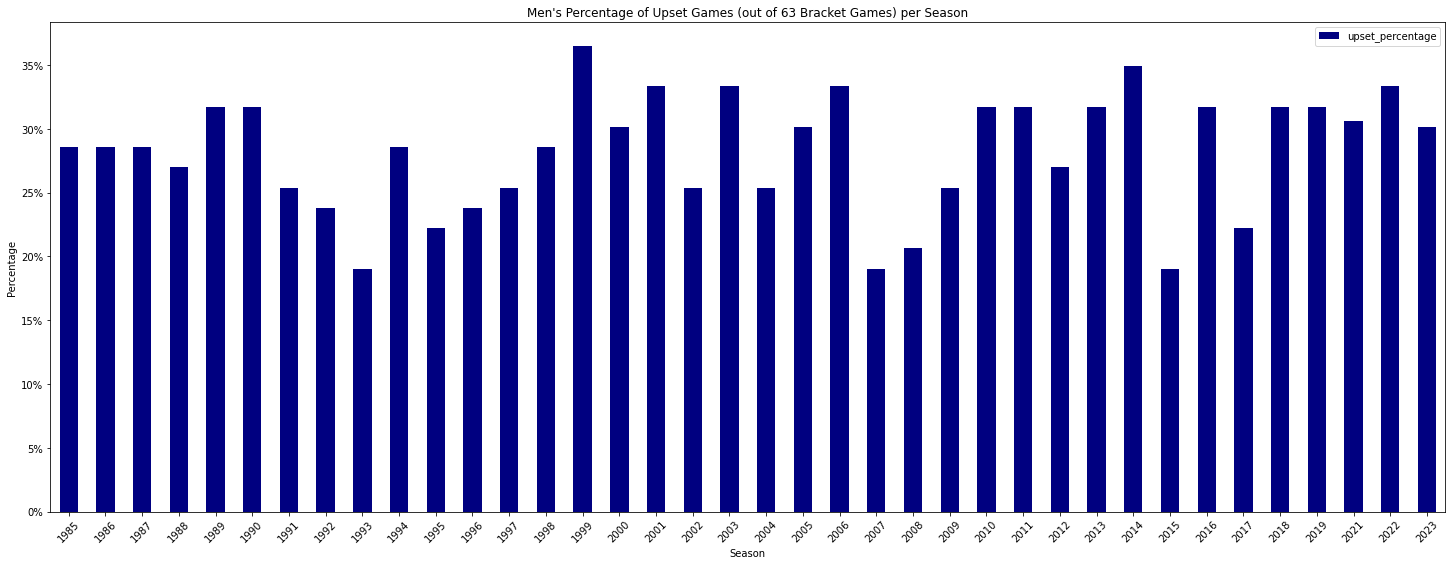

In [221]:
# plot men's percentage of upsets per season
mupset_percentage = (mupsets.groupby('Season').count() / df_mens.groupby('Season').count()).rename(columns={'LFullSeed': 'upset_percentage'}) \
    .reset_index()[['Season', 'upset_percentage']]
ax = mupset_percentage.plot(kind='bar', figsize=(25, 9), x='Season',y='upset_percentage', title='Men\'s Percentage of Upset Games (out of 63 Bracket Games) per Season', 
                            ylabel='Percentage', xlabel='Season', color='navy', rot=45)
ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])
plt.show()

In [222]:
# men's
mupset_percentage[['upset_percentage']].describe().T

,count,mean,std,min,25%,50%,75%,max
upset_percentage,38.0,0.282501,0.046472,0.190476,0.253968,0.285714,0.31746,0.365079


#### Round-by-Round Upsets in Men's Bracket

In [223]:
print('MEN\'S BRACKET:\n')

# look at upset % per round
for round in list(range(1,7)):
    print(f'Round {round} Upset %: {mupsets[mupsets["round"] == round].shape[0] / df_mens[df_mens["round"] == round].shape[0] * 100:.1f}% \
          ({mupsets[mupsets["round"] == round].shape[0]}/{df_mens[df_mens["round"] == round].shape[0]}) games \
          Avg Seed Diff: {mupsets[mupsets["round"] == round]["Wseed_diff"].mean():.2f}')

MEN'S BRACKET:

Round 1 Upset %: 25.9%           (315/1215) games           Avg Seed Diff: -5.14
Round 2 Upset %: 29.3%           (178/608) games           Avg Seed Diff: -5.12
Round 3 Upset %: 29.6%           (90/304) games           Avg Seed Diff: -3.44
Round 4 Upset %: 44.1%           (67/152) games           Avg Seed Diff: -2.67
Round 5 Upset %: 25.0%           (19/76) games           Avg Seed Diff: -2.68
Round 6 Upset %: 18.4%           (7/38) games           Avg Seed Diff: -2.71


In [224]:
# look at round upset % by season, if season has 0 games for a round, still display it
for round in list(range(1,7)):
    print(f'Round {round} Upset % by Season:')
    for season, group in df_mens[df_mens['round'] == round].groupby('Season'):
        print(f'{season}: {group[group["Wseed_diff"] < 0].shape[0] / df_mens[df_mens["round"] == round].loc[df_mens["Season"] == season].shape[0] * 100:.1f}% \
              ({group[group["Wseed_diff"] < 0].shape[0]}/{df_mens[df_mens["round"] == round].loc[df_mens["Season"] == season].shape[0]}) games \
              Avg Seed Diff: {group["Wseed_diff"].mean():.2f}')
    print()

Round 1 Upset % by Season:
1985: 21.9%               (7/32) games               Avg Seed Diff: 5.94
1986: 18.8%               (6/32) games               Avg Seed Diff: 5.62
1987: 28.1%               (9/32) games               Avg Seed Diff: 5.19
1988: 15.6%               (5/32) games               Avg Seed Diff: 6.19
1989: 37.5%               (12/32) games               Avg Seed Diff: 4.62
1990: 21.9%               (7/32) games               Avg Seed Diff: 5.81
1991: 28.1%               (9/32) games               Avg Seed Diff: 4.44
1992: 25.0%               (8/32) games               Avg Seed Diff: 5.75
1993: 18.8%               (6/32) games               Avg Seed Diff: 5.75
1994: 28.1%               (9/32) games               Avg Seed Diff: 6.19
1995: 25.0%               (8/32) games               Avg Seed Diff: 5.00
1996: 28.1%               (9/32) games               Avg Seed Diff: 5.69
1997: 21.9%               (7/32) games               Avg Seed Diff: 5.56
1998: 28.1%            

<ipython-input-225-b1da92f9d279>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax1.get_yticks()])


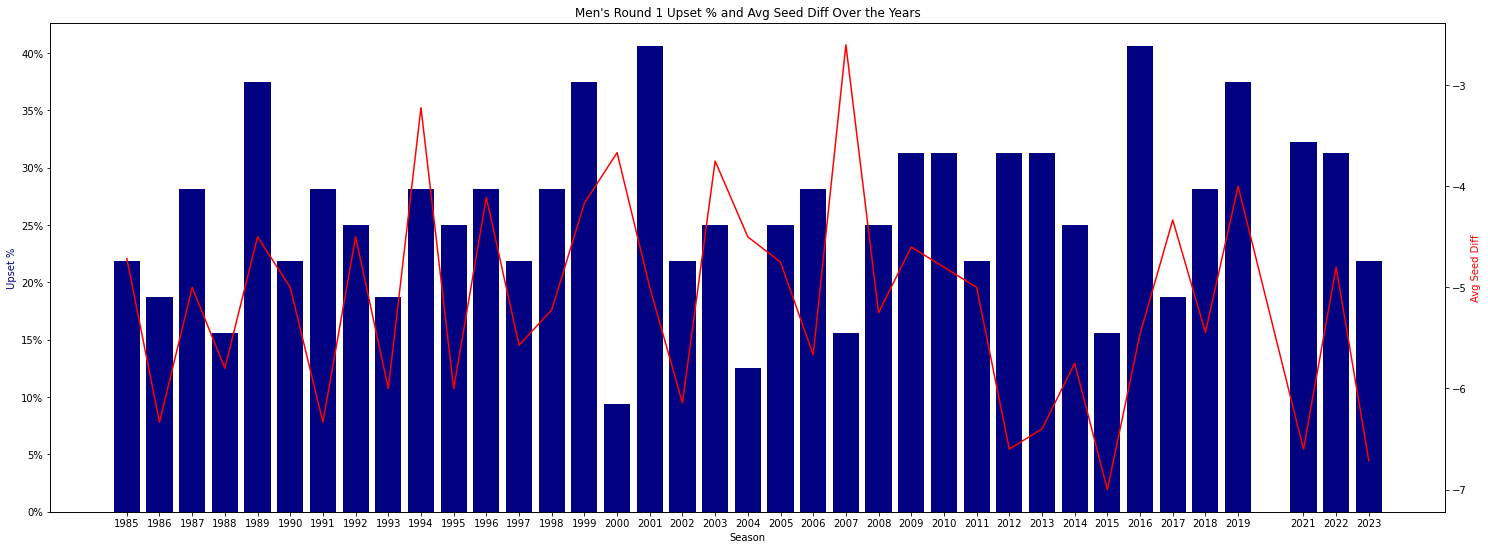

In [225]:
# plot round 1 upset percent and avg seed diff over the years
round_1_upset_percentage = (mupsets[mupsets['round'] == 1].groupby('Season').count() / df_mens[df_mens['round'] == 1].groupby('Season').count()).rename(columns={'LFullSeed': 'upset_percentage'}) \
    .reset_index()[['Season', 'upset_percentage']]
round_1_avg_seed_diff = mupsets[mupsets['round'] == 1].groupby('Season')['Wseed_diff'].mean().reset_index()
fig, ax1 = plt.subplots(figsize=(25, 9))
ax2 = ax1.twinx()
ax1.bar(round_1_upset_percentage['Season'], round_1_upset_percentage['upset_percentage'], color='navy', label='Upset %')
ax2.plot(round_1_avg_seed_diff['Season'].values, round_1_avg_seed_diff['Wseed_diff'].values, color='red', label='Avg Seed Diff')
ax1.set_xlabel('Season')
ax1.set_ylabel('Upset %', color='navy')
ax2.set_ylabel('Avg Seed Diff', color='red')
ax1.set_title('Men\'s Round 1 Upset % and Avg Seed Diff Over the Years')
ax1.set_xticks(round_1_upset_percentage['Season'])
ax1.set_xticklabels(round_1_upset_percentage['Season'])
ax1.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax1.get_yticks()])
plt.show()

In [226]:
# get abs value of seed diff so we can group
df_mens['abs_seed_diff'] = df_mens['Wseed_diff'].abs()

# print win % of each underdog seed diff group
for seed_diff in sorted(df_mens['abs_seed_diff'].unique())[1:]:
    print(f'-{seed_diff} seed diff win %: {df_mens.loc[(df_mens["abs_seed_diff"] == seed_diff) & (df_mens["Wseed_diff"] < 0)].shape[0] / df_mens.loc[df_mens["abs_seed_diff"] == seed_diff].shape[0] * 100:.1f}% \
            ({df_mens.loc[(df_mens["abs_seed_diff"] == seed_diff) & (df_mens["Wseed_diff"] < 0)].shape[0]}/{df_mens.loc[df_mens["abs_seed_diff"] == seed_diff].shape[0]}) games')

-1 seed diff win %: 45.2%             (179/396) games
-2 seed diff win %: 43.4%             (23/53) games
-3 seed diff win %: 37.2%             (118/317) games
-4 seed diff win %: 31.2%             (40/128) games
-5 seed diff win %: 34.1%             (90/264) games
-6 seed diff win %: 40.0%             (8/20) games
-7 seed diff win %: 30.4%             (75/247) games
-8 seed diff win %: 25.0%             (67/268) games
-9 seed diff win %: 20.1%             (36/179) games
-10 seed diff win %: 36.4%             (4/11) games
-11 seed diff win %: 12.8%             (22/172) games
-12 seed diff win %: 14.3%             (1/7) games
-13 seed diff win %: 7.2%             (11/152) games
-15 seed diff win %: 1.3%             (2/152) games


- Seed diffs of 2, 6, 10, and 12 have small sample sizes. Seed diff of 14 does not exist.
- These specific win %s will be filled in the following section.

In [227]:
# create dict mapping seed diff to win %
seed_diff_win_percentage = {}
for seed_diff in sorted(df_mens['abs_seed_diff'].unique(), reverse=True)[:-1]:
    seed_diff_win_percentage[-seed_diff] = df_mens.loc[(df_mens["abs_seed_diff"] == seed_diff) & (df_mens["Wseed_diff"] < 0)].shape[0] / df_mens.loc[df_mens["abs_seed_diff"] == seed_diff].shape[0]

# equal seeds have 50% win rate
seed_diff_win_percentage[0] = 0.5

# check
seed_diff_win_percentage

{-15: 0.013157894736842105,
 -13: 0.07236842105263158,
 -12: 0.14285714285714285,
 -11: 0.12790697674418605,
 -10: 0.36363636363636365,
 -9: 0.2011173184357542,
 -8: 0.25,
 -7: 0.30364372469635625,
 -6: 0.4,
 -5: 0.3409090909090909,
 -4: 0.3125,
 -3: 0.3722397476340694,
 -2: 0.4339622641509434,
 -1: 0.45202020202020204,
 0: 0.5}

In [228]:
# add win probs for seed diffs with 128 games or less of data
for i in [-14, -12, -10, -6, -4, -2]:
    seed_diff_win_percentage[i] = (seed_diff_win_percentage[i-1] + seed_diff_win_percentage[i+1]) / 2

# add positive seed diffs
for i in range(1, 16):
    seed_diff_win_percentage[i] = 1 - seed_diff_win_percentage[-i]

# check
sorted(seed_diff_win_percentage.items())

[(-15, 0.013157894736842105),
 (-14, 0.04276315789473684),
 (-13, 0.07236842105263158),
 (-12, 0.10013769889840882),
 (-11, 0.12790697674418605),
 (-10, 0.16451214758997013),
 (-9, 0.2011173184357542),
 (-8, 0.25),
 (-7, 0.30364372469635625),
 (-6, 0.3222764078027236),
 (-5, 0.3409090909090909),
 (-4, 0.3565744192715802),
 (-3, 0.3722397476340694),
 (-2, 0.41212997482713576),
 (-1, 0.45202020202020204),
 (0, 0.5),
 (1, 0.547979797979798),
 (2, 0.5878700251728642),
 (3, 0.6277602523659306),
 (4, 0.6434255807284198),
 (5, 0.6590909090909092),
 (6, 0.6777235921972764),
 (7, 0.6963562753036437),
 (8, 0.75),
 (9, 0.7988826815642458),
 (10, 0.8354878524100299),
 (11, 0.872093023255814),
 (12, 0.8998623011015912),
 (13, 0.9276315789473684),
 (14, 0.9572368421052632),
 (15, 0.9868421052631579)]

In [229]:
# add win prob col
df_mens['Wseed_win_prob'] = df_mens['Wseed_diff'].apply(lambda x: seed_diff_win_percentage[x])
df_mens['Lseed_win_prob'] = df_mens['Lseed_diff'].apply(lambda x: seed_diff_win_percentage[x])

# check
df_mens[['Wseed_diff', 'Wseed_win_prob', 'Lseed_diff', 'Lseed_win_prob']].head()

,Wseed_diff,Wseed_win_prob,Lseed_diff,Lseed_win_prob
0,-1,0.452020,1,0.547980
1,-5,0.340909,5,0.659091
2,15,0.986842,-15,0.013158
3,-1,0.452020,1,0.547980
4,11,0.872093,-11,0.127907


### Women's Upsets

In [8]:
# get favorite wins (lower/better seed wins), get upsets (higher/worse seed wins), and equal seed wins
wfavorites = df_womens.loc[df_womens['Wseed_diff'] > 0][['Season', 'WTeamID', 'LTeamID', 'WFullSeed', 'LFullSeed', 'Wseed_diff', 'round']]
wupsets = df_womens.loc[df_womens['Wseed_diff'] < 0][['Season', 'WTeamID', 'LTeamID', 'WFullSeed', 'LFullSeed', 'Wseed_diff', 'round']]
wequals = df_womens.loc[df_womens['Wseed_diff'] == 0][['Season', 'WTeamID', 'LTeamID', 'WFullSeed', 'LFullSeed', 'Wseed_diff', 'round']]

print('WOMEN\'S BRACKET:\n')
print(f'% of games where better seed won: {wfavorites.shape[0] / df_womens.shape[0] * 100: .2f}%, ({wfavorites.shape[0]}/{df_womens.shape[0]})')
print(f'% of games where worse seed won: {wupsets.shape[0] / df_womens.shape[0] * 100: .2f}%, ({wupsets.shape[0]}/{df_womens.shape[0]})')
print(f'% of games where seeds are equal: {wequals.shape[0] / df_womens.shape[0] * 100: .2f}%, ({wequals.shape[0]}/{df_womens.shape[0]})')

WOMEN'S BRACKET:

% of games where better seed won:  76.51%, (1205/1575)
% of games where worse seed won:  21.78%, (343/1575)
% of games where seeds are equal:  1.71%, (27/1575)


- It looks like results in the women's tournament are more 'chalked' (better seed wins 6% more often on average).

<ipython-input-231-21ce6fa99526>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])


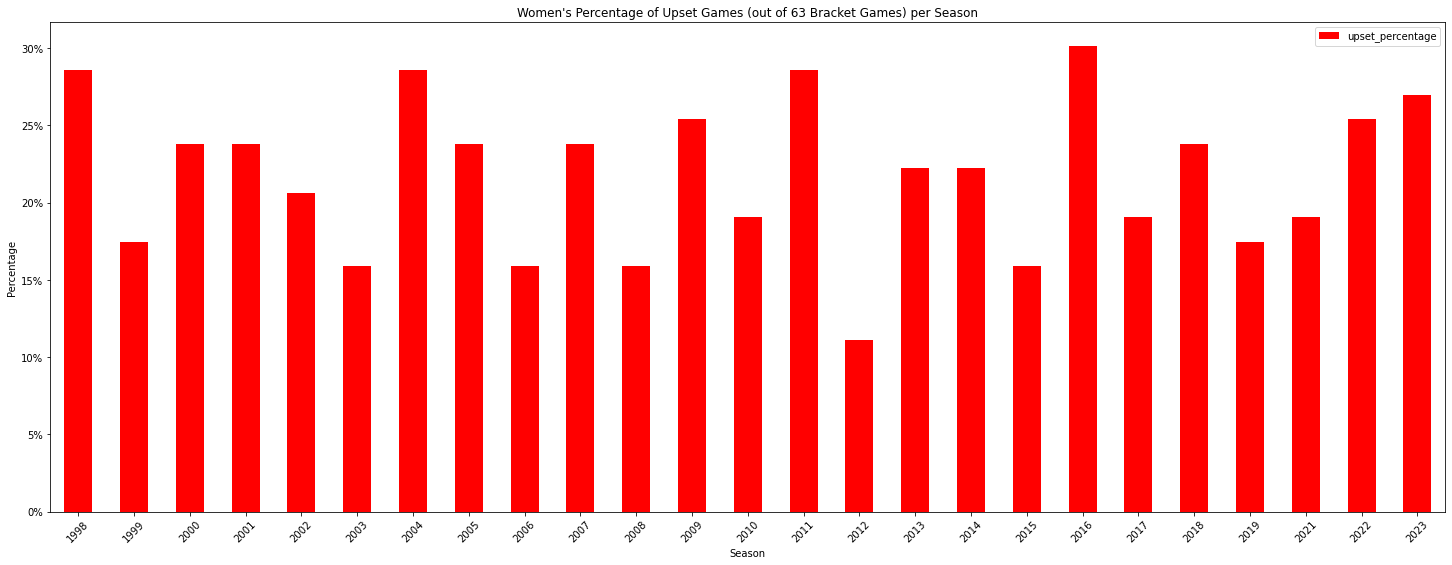

In [231]:
# plot women's percentage of upsets per season
wupset_percentage = (wupsets.groupby('Season').count() / df_womens.groupby('Season').count()).rename(columns={'LFullSeed': 'upset_percentage'}) \
    .reset_index()[['Season', 'upset_percentage']]
ax = wupset_percentage.plot(kind='bar', figsize=(25, 9), x='Season',y='upset_percentage', title='Women\'s Percentage of Upset Games (out of 63 Bracket Games) per Season', 
                            ylabel='Percentage', xlabel='Season', color='red', rot=45)
ax.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax.get_yticks()])
plt.show()

In [232]:
# men's
mupset_percentage[['upset_percentage']].describe().T

,count,mean,std,min,25%,50%,75%,max
upset_percentage,38.0,0.282501,0.046472,0.190476,0.253968,0.285714,0.31746,0.365079


In [233]:
# women's
wupset_percentage[['upset_percentage']].describe().T

,count,mean,std,min,25%,50%,75%,max
upset_percentage,25.0,0.217778,0.049884,0.111111,0.174603,0.222222,0.253968,0.301587


On average, the women's bracket has a 6.5% lower upset rate.

#### Round-by-Round Upsets in Women's Bracket

In [234]:
print('WOMEN\'S BRACKET:\n')

# look at upset % per round
for round in list(range(1,7)):
    print(f'Round {round} Upset %: {wupsets[wupsets["round"] == round].shape[0] / df_womens[df_womens["round"] == round].shape[0] * 100:.1f}% \
          ({wupsets[wupsets["round"] == round].shape[0]}/{df_womens[df_womens["round"] == round].shape[0]}) games \
          Avg Seed Diff: {wupsets[wupsets["round"] == round]["Wseed_diff"].mean():.2f}')

WOMEN'S BRACKET:

Round 1 Upset %: 18.5%           (148/800) games           Avg Seed Diff: -3.70
Round 2 Upset %: 24.8%           (99/400) games           Avg Seed Diff: -3.96
Round 3 Upset %: 25.5%           (51/200) games           Avg Seed Diff: -2.71
Round 4 Upset %: 28.0%           (28/100) games           Avg Seed Diff: -1.71
Round 5 Upset %: 26.0%           (13/50) games           Avg Seed Diff: -1.38
Round 6 Upset %: 16.0%           (4/25) games           Avg Seed Diff: -1.00


In [235]:
# look at round upset % by season, if season has 0 games for a round, still display it
for round in list(range(1,7)):
    print(f'Round {round} Upset % by Season:')
    for season, group in df_womens[df_womens['round'] == round].groupby('Season'):
        print(f'{season}: {group[group["Wseed_diff"] < 0].shape[0] / df_womens[df_womens["round"] == round].loc[df_womens["Season"] == season].shape[0] * 100:.1f}% \
              ({group[group["Wseed_diff"] < 0].shape[0]}/{df_womens[df_womens["round"] == round].loc[df_womens["Season"] == season].shape[0]}) games \
              Avg Seed Diff: {group["Wseed_diff"].mean():.2f}')
    print()

Round 1 Upset % by Season:
1998: 31.2%               (10/32) games               Avg Seed Diff: 5.00
1999: 15.6%               (5/32) games               Avg Seed Diff: 6.94
2000: 28.1%               (9/32) games               Avg Seed Diff: 5.81
2001: 18.8%               (6/32) games               Avg Seed Diff: 7.12
2002: 21.9%               (7/32) games               Avg Seed Diff: 6.44
2003: 6.2%               (2/32) games               Avg Seed Diff: 7.62
2004: 18.8%               (6/32) games               Avg Seed Diff: 6.38
2005: 21.9%               (7/32) games               Avg Seed Diff: 6.44
2006: 15.6%               (5/32) games               Avg Seed Diff: 6.56
2007: 15.6%               (5/32) games               Avg Seed Diff: 6.81
2008: 9.4%               (3/32) games               Avg Seed Diff: 7.44
2009: 25.0%               (8/32) games               Avg Seed Diff: 6.25
2010: 12.5%               (4/32) games               Avg Seed Diff: 6.75
2011: 18.8%              

- When seeds are unequal in the championship round, the better seed wins 73.33% of the time. If the seed diff is 2 or greater, the better seed has always won.
- Generally in the women's tournment the better seed wins if the seed diff is relatively large.

<ipython-input-236-b132614d4f27>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax1.get_yticks()])


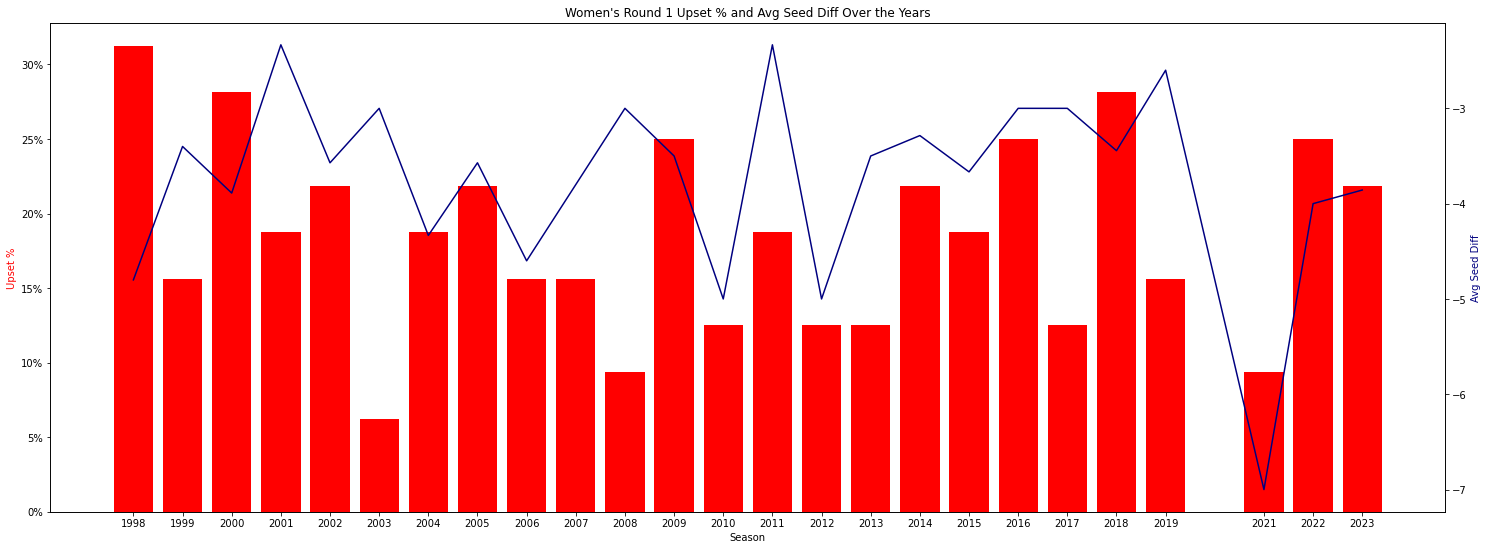

In [236]:
# plot round 1 upset percent and avg seed diff over the years
round_1_upset_percentage = (wupsets[wupsets['round'] == 1].groupby('Season').count() / df_womens[df_womens['round'] == 1].groupby('Season').count()).rename(columns={'LFullSeed': 'upset_percentage'}) \
    .reset_index()[['Season', 'upset_percentage']]
round_1_avg_seed_diff = wupsets[wupsets['round'] == 1].groupby('Season')['Wseed_diff'].mean().reset_index()
fig, ax1 = plt.subplots(figsize=(25, 9))
ax2 = ax1.twinx()
ax1.bar(round_1_upset_percentage['Season'], round_1_upset_percentage['upset_percentage'], color='red', label='Upset %')
ax2.plot(round_1_avg_seed_diff['Season'].values, round_1_avg_seed_diff['Wseed_diff'].values, color='navy', label='Avg Seed Diff')
ax1.set_xlabel('Season')
ax1.set_ylabel('Upset %', color='red')
ax2.set_ylabel('Avg Seed Diff', color='navy')
ax1.set_title('Women\'s Round 1 Upset % and Avg Seed Diff Over the Years')
ax1.set_xticks(round_1_upset_percentage['Season'])
ax1.set_xticklabels(round_1_upset_percentage['Season'])
ax1.set_yticklabels(['{:.0f}%'.format(x * 100) for x in ax1.get_yticks()])
plt.show()

In [237]:
# get abs value of seed diff so we can group
df_womens['abs_seed_diff'] = df_womens['Wseed_diff'].abs()

# print win % of each underdog seed diff group
for seed_diff in sorted(df_womens['abs_seed_diff'].unique())[1:]:
    print(f'-{seed_diff} seed diff win %: {df_womens.loc[(df_womens["abs_seed_diff"] == seed_diff) & (df_womens["Wseed_diff"] < 0)].shape[0] / df_womens.loc[df_womens["abs_seed_diff"] == seed_diff].shape[0] * 100:.1f}% \
            ({df_womens.loc[(df_womens["abs_seed_diff"] == seed_diff) & (df_womens["Wseed_diff"] < 0)].shape[0]}/{df_womens.loc[df_womens["abs_seed_diff"] == seed_diff].shape[0]}) games')

-1 seed diff win %: 44.6%             (135/303) games
-2 seed diff win %: 22.9%             (8/35) games
-3 seed diff win %: 32.3%             (76/235) games
-4 seed diff win %: 20.5%             (15/73) games
-5 seed diff win %: 28.2%             (49/174) games
-6 seed diff win %: 20.0%             (1/5) games
-7 seed diff win %: 17.2%             (27/157) games
-8 seed diff win %: 17.0%             (25/147) games
-9 seed diff win %: 5.3%             (6/113) games
-10 seed diff win %: 0.0%             (0/1) games
-11 seed diff win %: 0.0%             (0/103) games
-12 seed diff win %: 0.0%             (0/2) games
-13 seed diff win %: 0.0%             (0/100) games
-15 seed diff win %: 1.0%             (1/100) games


- Seed diffs of 2, 4, 6, 10, and 12 have small sample sizes. Once again, seed diff of 14 does not exist.
- Underdogs with seed diffs of 11 and 13 have never won in the women's bracket. Instead of placing these at 0%, we will impute them with 
- These specific win %s will be filled in the following section.

In [242]:
# create dict mapping seed diff to win %
seed_diff_win_percentage = {}
for seed_diff in sorted(df_womens['abs_seed_diff'].unique(), reverse=True)[:-1]:
    seed_diff_win_percentage[-seed_diff] = df_womens.loc[(df_womens["abs_seed_diff"] == seed_diff) & (df_womens["Wseed_diff"] < 0)].shape[0] / df_womens.loc[df_womens["abs_seed_diff"] == seed_diff].shape[0]

# equal seeds have 50% win rate
seed_diff_win_percentage[0] = 0.5

# check
seed_diff_win_percentage

{-15: 0.01,
 -13: 0.0,
 -12: 0.0,
 -11: 0.0,
 -10: 0.0,
 -9: 0.05309734513274336,
 -8: 0.17006802721088435,
 -7: 0.17197452229299362,
 -6: 0.2,
 -5: 0.28160919540229884,
 -4: 0.2054794520547945,
 -3: 0.32340425531914896,
 -2: 0.22857142857142856,
 -1: 0.44554455445544555,
 0: 0.5}

In [243]:
# add win probs for seed diffs -14 through -10
diff = (seed_diff_win_percentage[-9] - seed_diff_win_percentage[-15]) / 6

for i in range(-14, -9):
    seed_diff_win_percentage[i] = seed_diff_win_percentage[i-1] + diff

# add win probs for seed diffs -6, -4, and -2
for i in [-6, -4, -2]:
    seed_diff_win_percentage[i] = (seed_diff_win_percentage[i-1] + seed_diff_win_percentage[i+1]) / 2

# add positive seed diffs
for i in range(1, 16):
    seed_diff_win_percentage[i] = 1 - seed_diff_win_percentage[-i]

# check
sorted(seed_diff_win_percentage.items())

[(-15, 0.01),
 (-14, 0.017182890855457225),
 (-13, 0.024365781710914452),
 (-12, 0.03154867256637168),
 (-11, 0.0387315634218289),
 (-10, 0.04591445427728613),
 (-9, 0.05309734513274336),
 (-8, 0.17006802721088435),
 (-7, 0.17197452229299362),
 (-6, 0.22679185884764624),
 (-5, 0.28160919540229884),
 (-4, 0.30250672536072387),
 (-3, 0.32340425531914896),
 (-2, 0.3844744048872972),
 (-1, 0.44554455445544555),
 (0, 0.5),
 (1, 0.5544554455445545),
 (2, 0.6155255951127028),
 (3, 0.676595744680851),
 (4, 0.6974932746392761),
 (5, 0.7183908045977012),
 (6, 0.7732081411523537),
 (7, 0.8280254777070064),
 (8, 0.8299319727891157),
 (9, 0.9469026548672567),
 (10, 0.9540855457227139),
 (11, 0.9612684365781711),
 (12, 0.9684513274336283),
 (13, 0.9756342182890856),
 (14, 0.9828171091445428),
 (15, 0.99)]

In [244]:
# add win prob col
df_womens['Wseed_win_prob'] = df_womens['Wseed_diff'].apply(lambda x: seed_diff_win_percentage[x])
df_womens['Lseed_win_prob'] = df_womens['Lseed_diff'].apply(lambda x: seed_diff_win_percentage[x])

# check
df_womens[['Wseed_diff', 'Wseed_win_prob', 'Lseed_diff', 'Lseed_win_prob']].head()

,Wseed_diff,Wseed_win_prob,Lseed_diff,Lseed_win_prob
0,13,0.975634,-13,0.024366
1,11,0.961268,-11,0.038732
2,13,0.975634,-13,0.024366
3,3,0.676596,-3,0.323404
4,-3,0.323404,3,0.676596


## Additional Data

In [65]:
# load data
# ordinals = pd.read_csv(mroot + 'MMasseyOrdinals.csv')
# coaches = pd.read_csv(mroot + 'MTeamCoaches.csv')
conf_games = pd.read_csv(mroot + 'MConferenceTourneyGames.csv')

In [71]:
conf_games

,Season,ConfAbbrev,DayNum,WTeamID,LTeamID
0,2001,a_sun,121,1194,1144
1,2001,a_sun,121,1416,1240
2,2001,a_sun,122,1209,1194
3,2001,a_sun,122,1359,1239
4,2001,a_sun,122,1391,1273
...,...,...,...,...,...
6486,2024,wcc,124,1365,1360
6487,2024,wcc,125,1362,1339
6488,2024,wcc,126,1211,1362
6489,2024,wcc,126,1388,1365


In [75]:
conf_games.groupby(['Season', 'ConfAbbrev'])['DayNum'].describe().tail(100)

count        mean       std    min     25%    50%     75%  \
Season ConfAbbrev                                                              
2021   sun_belt     11.0  124.000000  1.000000  123.0  123.00  124.0  124.50   
       swac          7.0  129.285714  1.112697  128.0  128.50  129.0  130.00   
       wac           5.0  129.800000  0.836660  129.0  129.00  130.0  130.00   
       wcc           9.0  124.111111  1.833333  122.0  123.00  124.0  126.00   
2022   a_sun        11.0  122.090909  2.211540  120.0  120.00  122.0  123.00   
       a_ten        13.0  129.692308  1.182132  128.0  129.00  130.0  130.00   
       aac          10.0  130.100000  0.994429  129.0  129.25  130.0  130.75   
       acc          14.0  128.571429  1.222500  127.0  128.00  128.5  129.00   
       aec           7.0  126.714286  2.360387  125.0  125.00  125.0  128.00   
       big_east     10.0  129.100000  0.994429  128.0  128.25  129.0  129.75   
       big_sky      10.0  129.100000  0.994429  128.0  128.25  129.0  129.75   
       big_south    11.0  122.636364  1.433369  121.0  121.00  123.0  123.50   
       big_ten      13.0  129.692308  1.182132  128.0  129.00  130.0  130.00   
       big_twelve    8.0  129.375000  0.916125  128.0  129.00  129.0  130.00   
       big_west      9.0  129.000000  1.322876  127.0  129.00  129.0  130.00   
       caa           8.0  125.375000  0.916125  124.0  125.00  125.0  126.00   
       cusa         13.0  128.692308  1.182132  127.0  128.00  129.0  129.00   
       horizon      11.0  122.454545  2.659460  120.0  120.00  122.0  124.00   
       ivy           3.0  131.333333  0.577350  131.0  131.00  131.0  131.50   
       maac         10.0  128.600000  1.429841  127.0  127.25  128.5  129.75   
       mac           7.0  129.571429  0.786796  129.0  129.00  129.0  130.00   
       meac          7.0  129.285714  1.112697  128.0  128.50  129.0  130.00   
       mvc           9.0  123.222222  0.971825  122.0  123.00  123.0  124.00   
       mwc          10.0  129.100000  0.994429  128.0  128.25  129.0  129.75   
       nec           8.0  122.250000  2.549510  119.0  121.00  121.0  124.00   
       ovc           7.0  122.285714  1.112697  121.0  121.50  122.0  123.00   
       pac_twelve   11.0  129.000000  1.000000  128.0  128.00  129.0  129.50   
       patriot       9.0  122.888889  2.619372  120.0  122.00  122.0  125.00   
       sec          13.0  129.692308  1.182132  128.0  129.00  130.0  130.00   
       southern      9.0  124.222222  0.971825  123.0  124.00  124.0  125.00   
       southland     7.0  129.285714  1.112697  128.0  128.50  129.0  130.00   
       summit        7.0  125.285714  1.112697  124.0  124.50  125.0  126.00   
       sun_belt     11.0  123.636364  1.433369  122.0  122.00  124.0  124.50   
       swac          7.0  129.285714  1.112697  128.0  128.50  129.0  130.00   
       wac           9.0  128.777778  1.394433  127.0  128.00  129.0  130.00   
       wcc           9.0  124.111111  1.833333  122.0  123.00  124.0  126.00   
2023   a_sun         9.0  120.777778  1.922094  119.0  120.00  120.0  122.00   
       a_ten        14.0  128.785714  1.577660  127.0  128.00  128.5  129.00   
       aac          10.0  130.100000  0.994429  129.0  129.25  130.0  130.75   
       acc          14.0  128.571429  1.222500  127.0  128.00  128.5  129.00   
       aec           7.0  125.857143  2.672612  124.0  124.00  124.0  127.00   
       big_east     10.0  129.100000  0.994429  128.0  128.25  129.0  129.75   
       big_sky       9.0  125.777778  1.394433  124.0  125.00  126.0  127.00   
       big_south     9.0  123.000000  1.322876  121.0  123.00  123.0  124.00   
       big_ten      13.0  129.692308  1.182132  128.0  129.00  130.0  130.00   
       big_twelve    9.0  129.222222  0.971825  128.0  129.00  129.0  130.00   
       big_west      9.0  129.000000  1.322876  127.0  129.00  129.0  130.00   
       caa          12.0  124.833333  1.114641  123.0  124.00  125.0  125.25   
       cusa        

Conference tourney games ARE contained in the regular season games table

In [245]:
# combine df_mens and df_womens
df = pd.concat([df_mens, df_womens], ignore_index=True).reset_index(drop=True)

# save to csv
df.to_csv('data/processed/features_detailed.csv', index=False)

In [4]:
# load saved df
df = pd.read_csv('data/processed/features_compact.csv')